## Hybrid(Section毎＋全体チャンク化、re-rank) Normalize

```
ノート全体と、Section毎にチャンク化してVector StoreとBM Indexに格納。  
３つの入力領域を＋対応するクエリで検索する＋ノート全体を結合したクエリで検索する。  
各クエリは、VectorSearchとBM25Searchで行い、RRFでランク統合を行い、rerankを行う。
   QueryA -+- embedding - VectorSearch -+-> RRF --> rerank -+- Aggregate -> topK 
           +- Tokenize  - BM25Search   -+                   |
   QueryB -       同上                                     -+
   QueryC -       同上                                     -+
   QueryA+B+C -   同上                                     -+
   
４つのクエリの結果を、同じノート毎に集約する。集約時の計算は相加平均または最大値。  
材料のデータに関しては名寄せを実施。  

pip install rank_bm25
pip install SudachiPy sudachidict_core sudachidict_full
pip install transformers sentence-transformers

### 各種設定

In [2]:
import re, glob, time
import numpy as np
import pandas as pd
pd.set_option('display.width', 150)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows',  None)
from pprint import pprint
from collections import defaultdict

from sentence_transformers import SentenceTransformer # embedding用
import google.genai as genai
import openai
import cohere
import chromadb
import sudachipy
from sudachipy import Dictionary, SplitMode # 日本語Tokenizer
from rank_bm25 import BM25Okapi, BM25Plus   # BM25
import langchain_core
from langchain_core.documents import Document
from langchain_core.stores    import InMemoryStore # 親チャンク用(未使用)
from sklearn.metrics import ndcg_score

print(f"genai={genai.__version__}, openai={openai.__version__}, " + 
      f"cohere={cohere.__version__}, chromadb={chromadb.__version__}, " +
      f"sudachipy={sudachipy.__version__}, " +
      f"langchain_core={langchain_core.__version__}, ")

genai=1.56.0, openai=2.13.0, cohere=5.20.0, chromadb=1.3.7, sudachipy=0.6.10, langchain_core=1.2.2, 


#### LLMモデル利用定義

In [2]:
# Geminiモデルを指定
GEMINI_EMBEDDING_MODEL = 'gemini-embedding-001'
#GEMINI_LLM_MODEL      = 'gemini-2.0-flash'  # Limit-Rateが高い
#GEMINI_LLM_MODEL      = 'gemini-2.5-flash'  # それなりに賢い
#GEMINI_LLM_MODEL      = 'gemini-2.5-pro'
#GEMINI_LLM_MODEL      = 'gemini-3-pro-preview'

# OpenAIモデルを指定
OPENAI_EMBEDDING_MODEL_SMALL = 'text-embedding-3-small'
OPENAI_EMBEDDING_MODEL_LARGE = 'text-embedding-3-large'

# Cohereモデルを指定
#COHERE_EMBEDDING_MODEL = 'embed-v4.0'
COHERE_LLM_MODEL       = 'command-a-03-2025'
COHERE_RERANK_MODEL     = 'rerank-v3.5'

# Geminiクライアントを作成
with open('keys/Google_API_KEY.txt', 'r') as f:
    api_key = f.read().strip()
GEMINI_CLIENT = genai.Client(api_key=api_key)

# Cohereクライアントを作成
with open('keys/Cohere_API_KEY.txt', 'r') as f:
    api_key = f.read().strip()
COHERE_CLIENT = cohere.ClientV2(api_key=api_key)

# OpenAIクライアントを作成
with open('keys/OpenAI_API_KEY.txt', 'r') as f:
    api_key = f.read().strip()
OPENAI_CLIENT = openai.OpenAI(api_key=api_key)

# Chromaクライアントを作成
CHROMA_CLIENT = chromadb.EphemeralClient()  # インメモリで作成

# PLaMoクライアントを作成
PLAMO_CLIENT = SentenceTransformer('pfnet/plamo-embedding-1b', trust_remote_code=True)

# ruriクライアントを作成
RURI_CLIENT = SentenceTransformer('cl-nagoya/ruri-v3-310m', trust_remote_code=True)

from enum import Enum, auto
class EmbeddingType(Enum): # モデル切り替え用定数の設定
    GEMINI = auto()
    OPENAI_SMALL = auto()
    OPENAI_LARGE = auto()
#    COHERE = auto()  # 未使用
    PLAMO  = auto()
    RURI   = auto()
#======================================
EMBEDDING_MODEL = EmbeddingType.GEMINI   # モデルを指定
#======================================

No sentence-transformers model found with name pfnet/plamo-embedding-1b. Creating a new one with mean pooling.


#### embedding関数

In [3]:
def get_embeddings(texts):
    """共通のEmbedding関数"""

    # 単一文字列でも対応
    single_input = False
    if isinstance(texts, str):
        texts = [texts]
        single_input = True

    match EMBEDDING_MODEL:

        # Gemini
        case EmbeddingType.GEMINI:
            # Embedding取得
            response = GEMINI_CLIENT.models.embed_content(
                model=GEMINI_EMBEDDING_MODEL,
                contents=texts
            )
            embeddings = [e.values for e in response.embeddings]

        # OpenAI
        case EmbeddingType.OPENAI_SMALL | EmbeddingType.OPENAI_LARGE:
            if EMBEDDING_MODEL == EmbeddingType.OPENAI_LARGE:
                OPENAI_EMBEDDING_MODEL = OPENAI_EMBEDDING_MODEL_LARGE 
            else:
                OPENAI_EMBEDDING_MODEL = OPENAI_EMBEDDING_MODEL_SMALL 
            # Embeddings を取得
            response = OPENAI_CLIENT.embeddings.create(
                model=OPENAI_EMBEDDING_MODEL,
                input=texts
            )
            # レスポンスからベクトル抽出（resp.data は入力ごとの要素を持つ）
            embeddings = [d.embedding for d in response.data]

        # PLaMo
        case EmbeddingType.PLAMO:
            embeddings = PLAMO_CLIENT.encode(
                texts,
                batch_size=16,
                show_progress_bar=False,
                convert_to_numpy=True
            )

        # Ruri
        case EmbeddingType.RURI:
            embeddings = RURI_CLIENT.encode(
                texts, 
                batch_size=16, 
                convert_to_numpy=True, 
                show_progress_bar=False
            )
    
    # 単一入力だったら一次元のリストを返す
    if single_input:
        return embeddings[0]

    return embeddings

# 確認
print(f"EMBEDDING_MODEL={EMBEDDING_MODEL}")
for texts in ['今日はいい天気です。', ['今日はいい天気です。','明日はどうでしょうか？']]:
    embedded_text = get_embeddings(texts)
    if isinstance(embedded_text, np.ndarray):
        print(f"{type(embedded_text)}, {embedded_text.shape}, {embedded_text.flatten()[:4]} ...")
    else:
        try:
            print(f"{type(embedded_text)}, {len(embedded_text)}, {embedded_text[0][:4]} ...")
        except:
            print(f"{type(embedded_text)}, {len(embedded_text)}, {embedded_text[:4]} ...")

EMBEDDING_MODEL=EmbeddingType.GEMINI
<class 'list'>, 3072, [-0.019278863, -0.0022764413, 0.0021871584, -0.08121658] ...
<class 'list'>, 2, [-0.019278863, -0.0022764413, 0.0021871584, -0.08121658] ...


#### 日本語 Tokenizer

入力文を、形態素解析エンジンでトークン化、必要な品詞のみのトークンのリストを返す  

In [4]:
### すだち
dict_obj = Dictionary(dict='full', config_path='./sudachi.json')
tokenizer = dict_obj.create()

# <Morpheme(撹拌条件, 0:4, (1, 0))>, 入力, 辞書マッチ範囲, (1:user.dic, 単語ID)
print([dict_obj.lookup('撹拌条件')]) # User_dic確認 辞書になければ[]
print([dict_obj.lookup('hba1c')])

def tokenize(text, splitmode='C', pos=False):

    match splitmode.upper():
        case 'A':
            splitmode = SplitMode.A # 超細かい
        case 'B':
            splitmode = SplitMode.B # 細かい
        case _:
            splitmode = SplitMode.C

    tokens = tokenizer.tokenize(text, splitmode) # Defult = SplitMode.C
    if pos:
        pprint([(t.surface(), t.part_of_speech()) for t in tokens])
    tokens = [t.surface() for t in tokens]
    return tokens

def tokenize_and_filter_by_pos(
    text, 
    target_pos=['名詞','動詞','形容詞','副詞','接頭詞'],
    pos=False
):
    # 入力文から指定された品詞のトークンを抽出
    tokens = list(tokenizer.tokenize(text))
    if pos:
        pprint([(t.surface(), t.part_of_speech()) for t in tokens])
    parts_of_speech = [t.part_of_speech() for t in tokens]                             # 品詞情報を抽出
    is_target_pos = [bool(set(p) & set(target_pos)) and 
                     not (bool(set(p) & set(['動詞'])) and
                          bool(set(p) & set(['非自立', '非自立可能'])))
                                                             for p in parts_of_speech] # 必要品詞で抽出
    #pprint(is_target_pos)
    extracted_tokens = [t.surface() for (t, f) in zip(tokens, is_target_pos) if f]
    return extracted_tokens

def tokenize_detail_info(text):
    tokens = tokenizer.tokenize(text, SplitMode.C)
    print(f"# INPUT: {[m.surface() for m in tokens]}")
    for m in tokens:
        print(f"\nsurface(): {m.surface()} {'-'*10}",
              f"\ndictionary_id(0:System, 1:User): {m.dictionary_id()}", 
              f"\ndictionary_form(見出し): {m.dictionary_form()}", 
              f"\nnormalized_form(正規化表記): {m.normalized_form()}",
              f"\npart_of_speech(品詞): {m.part_of_speech()}",
              f"\npart_of_speech_id(): {m.part_of_speech_id()}",
              f"\nraw_surface(入力): {m.raw_surface()}",
              f"\nreading_form(読み): {m.reading_form()}",
              f"\nsynonym_group_ids(同義語辞書でのID): {m.synonym_group_ids()}",
              f"\nword_id(): {m.word_id()}",
              f"\nis_oov(未知語): {m.is_oov()}",
             )

pprint(tokenize('① 今日は、良い天気です。', pos=True))
pprint(tokenize('p-トルエンスルホン酸', pos=True))
pprint(tokenize_and_filter_by_pos('① 今日は、良い天気です。', pos=True))
pprint(tokenize_detail_info('実験装置'))

[<MorphemeList[
  <Morpheme(撹拌条件, 0:4, (1, 0))>,
]>]
[<MorphemeList[
  <Morpheme(hba1c, 0:5, (1, 46))>,
]>]
[('①', ('名詞', '数詞', '*', '*', '*', '*')),
 (' ', ('空白', '*', '*', '*', '*', '*')),
 ('今日', ('名詞', '普通名詞', '副詞可能', '*', '*', '*')),
 ('は', ('助詞', '係助詞', '*', '*', '*', '*')),
 ('、', ('補助記号', '読点', '*', '*', '*', '*')),
 ('良い', ('形容詞', '非自立可能', '*', '*', '形容詞', '連体形-一般')),
 ('天気', ('名詞', '普通名詞', '一般', '*', '*', '*')),
 ('です', ('助動詞', '*', '*', '*', '助動詞-デス', '終止形-一般')),
 ('。', ('補助記号', '句点', '*', '*', '*', '*'))]
['①', ' ', '今日', 'は', '、', '良い', '天気', 'です', '。']
[('p-トルエンスルホン酸', ('名詞', '普通名詞', '一般', '*', '*', '*'))]
['p-トルエンスルホン酸']
[('①', ('名詞', '数詞', '*', '*', '*', '*')),
 (' ', ('空白', '*', '*', '*', '*', '*')),
 ('今日', ('名詞', '普通名詞', '副詞可能', '*', '*', '*')),
 ('は', ('助詞', '係助詞', '*', '*', '*', '*')),
 ('、', ('補助記号', '読点', '*', '*', '*', '*')),
 ('良い', ('形容詞', '非自立可能', '*', '*', '形容詞', '連体形-一般')),
 ('天気', ('名詞', '普通名詞', '一般', '*', '*', '*')),
 ('です', ('助動詞', '*', '*', '*', '助動詞-デス

#### 材料データ名寄せ関数

In [5]:
# 名寄せデータ
Entity_Resolution_dic = {
    r"f(ab')2": r"f(ab')2コートラテックス",
    r"IgG":     r"IgGコートラテックス",
    r"純水":    r"精製水",
}

#分解パターンの定義
# 正規表現
# 末尾の数量、単位の分離 (省略可)
qty_unit_pattern = re.compile(
    r"""
    \s*[:：]*\s*             # 0個以上の空白、セパレータ、空白
    (?P<qty>[\d.,]+)         # 数量 (数値)
    \s*                      # 0個以上の空白
    (?P<unit>[kKmnμµ]{0,1}[a-zA-Z]+|[日時分秒℃度%]|°[CK]|rpm|mol|min|sec)?  # 単位 (省略可) <= 工夫の余地あり
    $                        # 末尾
    """,
    re.VERBOSE
)

ZEN2HAN = str.maketrans(
    "".join(chr(0xff01 + i) for i in range(94))+"　", # Zen
    "".join(chr(0x21   + i) for i in range(94))+" "   # Han
)

def parse_material(line, trace=False):
    '''
    材料行を分解
    材料と数量単位は、空白またはセパレータ[:：]で分かち書きされている
    以下に分解
    1. 先頭[-*・] (無い場合がある) => 無視
    2. 項番: 例: ①,... (1),...   (無い場合がある) => 無視
    3. 材料: 材料名, 補足
      3.1 材料名 数値を含む場合あり => 変数 mate に格納
      3.2 補足「()（）」で囲まれた補足情報が続く場合もあり => ()含め変数 add に格納
    4. 数量, 単位: 無い場合もあり、 数量と単位に間に空白がある場合と無い場合がある
    　4.1 数量(数値、半角または全角、「,.」を含む) => 変数 qtyに格納　
      4.2 単位((L,g)x(そのまま、k,m,μ))、ignore case) => 変数 unit に格納
    '''
    line = line.strip().replace("　", " ")                 # 前後余白を削除、全角スペースを半角に
    line = re.sub(r'^[\-\*]+\s*', '', line)                # 先頭の "-", "*", "•" を除去
    line = re.sub(r'^\s*(\(?\d+\)?|[①-⑳])\s*', '', line)   # 項番（①, ②, (1), 1. など）を除去
    line = line.translate(ZEN2HAN).strip()                 # 数字記号は半角に
    if trace:
        print(f"## {line}")

    # 1. 正規化：セパレータは「空白 or : or ：」
    #    最後の数量部分を優先的に捉えるため "数量+単位" をパターン化して先に抽出
    qty = ''; unit = ''
    m = qty_unit_pattern.search(line)
    if m:
        qty  = m.group('qty')
        unit = m.group('unit')
        # 数量部分を取り除いて「材料側」だけにする
        line_material = line[:m.start()].rstrip()
    else:
        # 数量・単位なし
        line_material = line.strip()

    # 2. 材料名末尾に続く補足括弧を抽出（複数対応）
    #   材料名内部にある括弧は mate に含める
    add = ''
    add_list = []

    # 補足括弧は、文末方向に連続しているものだけ抽出
    add_pattern = re.compile(r"(\([^)]*\)|（[^）]*）)$")

    tmp = line_material
    while True:
        m = add_pattern.search(tmp)
        if not m:
            break
        add_list.insert(0, m.group(1))  # 先頭に挿入して順序維持
        tmp = tmp[:m.start()].rstrip()

    if add_list:
        add = ''.join(add_list)
        mate = tmp.strip()
    else:
        mate = line_material.strip()

    mate_dic = {'material': mate, 'add': add, 'qty': qty, 'unit': unit}
    if trace:
        print(f"## ## {mate_dic}")
    mate_dic = {k: v for k, v in mate_dic.items() if v != '' and v is not None} # 値が''の要素をdrop
    if trace:
        print(f"## ## {mate_dic}")

    return mate_dic


def parse_and_normalize_materials(material_section, trace=False):
    materials = ''
    lines = material_section.strip().split('\n')
    if trace:
        change = []
    for line in lines:
        line = line.strip()
        if line =='':
            continue
        mate_dic = parse_material(line, trace=trace) # 「材料名 (補足) 数量 単位」に分解
        if mate := mate_dic.get('material', False):  # 材料名があれば、
            normalized_mate = Entity_Resolution_dic.get(mate, mate) # 名寄せ
            mate_dic['material'] =  normalized_mate                 # 名寄せ
            if trace:
                change.append('->') if normalized_mate != mate else change.append('--')            
        materials += ' '.join(list(mate_dic.values())) + '\n'

    if trace:
        for i, (org, chg, nor) in enumerate(zip(lines, change, materials.split('\n')),start=1):
            print(f"{i}, {org} {chg} {nor}")
    return materials

# 動作確認
tests = '''
- ① 純水：20 μL
* (2) エタノール: 5,000mol
精製水 100°K
水:　１０ ml
水  10秒
食塩水(5%) 10ml
- ⑥ IgG（粒径 100 nm）：1 mL
- ⑦ f(ab')2（粒径 200 nm）：1 mL
- ⑥ IgGコートラテックス（粒径 100 nm）：1 mL
'''
pprint(parse_and_normalize_materials(tests, trace=False))

('精製水 20 μL\n'
 'エタノール 5,000 mol\n'
 '精製水 100 °K\n'
 '水 10 ml\n'
 '水 10 秒\n'
 '食塩水 (5%) 10 ml\n'
 'IgGコートラテックス (粒径 100 nm) 1 mL\n'
 "f(ab')2コートラテックス (粒径 200 nm) 1 mL\n"
 'IgGコートラテックス (粒径 100 nm) 1 mL\n')


#### データ読込関数
データを、ノート名・セクションの辞書の形で返す

In [6]:
def read_dataset(doc_dir='notes', trace=False): # -> dic
    """実験ノート(md)の読み込み"""
    indata_section_names = ['目的','材料','実験手順'] # 入力データでのSection名

    # doc_dir以下のすべての .md ファイルを取得
    md_files = glob.glob(f"./{doc_dir}/*.md")

    # レシピを辞書に格納
    notes_dic = {}
    for i, file_path in enumerate(md_files, start=1):
        with open(file_path, "r", encoding="utf-8") as f:
            note = f.read().strip()
            name = re.search(r"^# (.+)$", note, re.MULTILINE).group(1).strip()
            notes_dic[name] = note.strip()
    print(f"\ndoc_dir={doc_dir}, 読みこんだレシピの数: {len(notes_dic)}")
    if trace:
        first_key = list(notes_dic.keys())[0]; print(notes_dic[first_key]) # 最初のレシピ

    # セクションごとに辞書化
    section_pattern = re.compile(r'^## (.*?)\n(.*?)(?=\n## |\Z)', re.MULTILINE | re.DOTALL)
    for i, (name, note) in enumerate(notes_dic.items()):
        if trace:
            print(f"## {name} ====")
        matches = section_pattern.findall(note)  # セクションごとに分離辞書化
        result_dic = {title.strip(): content.strip() for title, content in matches}

        # Section名を標準化
        for (std_name, indata_name) in zip(SECTION_NAMES, indata_section_names):
            if std_name != indata_name:
                result_dic[std_name] = result_dic.pop(indata_name)
        if MATE_NORMALIZE:
            result_dic['材料'] = parse_and_normalize_materials(result_dic['材料'], trace=trace) # 材料の正規化

        # allの追加
        result_dic['all'] = '\n\n'.join([f"## {s}\n\n{result_dic[s]}" for s in SECTION_NAMES])

        notes_dic[name] = result_dic
    first_key = list(notes_dic.keys())[0]
    print(f"\n辞書化したノートの数: {len(notes_dic)}\nFirst: {first_key}: {notes_dic[first_key].keys()}")
    pprint(notes_dic[first_key])

    return notes_dic

#### Vector Store/BM25 Index 作成関数
実験ノートデータを読み込み、Section毎＋全体 毎に、Vector Store および MB25 Indexを作成  
Vector Store では Metadataに、(1)ノート名、(2)セクション名or'all'を付与

In [7]:
from tqdm import tqdm
def setup_stores(notes_dic):
    """
    コレクション,インデックスのセットアップ
    Arg:
        notes_dic: {'all': [ノート1,ノート2,...], '目的':[ノート1,ノート1,...], ...}
    return:
        collection:    VectorStore
        bm25index_dic: {'all', BM25index_all, '目的', tokenized_purposes, ...}
        doc_ids:       ['doc'ノート1名'_all', ...]
    """

    # collection作成 (すでに在ったら削除)
    collection_name = 'notes'
    try:
        CHROMA_CLIENT.delete_collection(collection_name)
    except:
        pass
    collection = CHROMA_CLIENT.create_collection(
        name = collection_name,
        metadata={'hnsw:space': 'cosine'}  # 距離メトリック = 'cosine'
    )

    doc_ids  = []
    tokenized_alls      = []
    tokenized_purposes  = []
    tokenized_materials = []
    tokenized_methods   = []
    names = list(notes_dic.keys())    # ノート名
    n = 10 # 一度に処理するノート数（x section数 = バッチサイズ） token size limit対策
    for i in tqdm(range(0, len(names), n), mininterval=2, ncols=80): # バッチ毎に
        page_contents = []
        metadatas     = []
        ids           = []

        for j in range(i, min(i+n, len(names))): # ノート毎に
            name = names[j]
            note_dic = notes_dic[name]
            doc_ids.append(name)

            for k, s in enumerate(note_dic.keys(), start=1): # section毎に
                doc_id = f"{name}_{s}"
                ids.append(doc_id)    # id: ユニークな文字列
                
                # for Vector store ==========================
                section = f"## {s}:\n{note_dic[s].strip()}"
                page_contents.append(section)
                metadatas.append({'source': name, 'section': s})

                # for BM25 Index ==========================
                tokenized_section = tokenize_and_filter_by_pos(section)
                match s:
                    case s if s=='all':
                        tokenized_alls.append(tokenized_section)
                    case s if s==SECTION_NAMES[0]:
                        tokenized_purposes.append(tokenized_section)
                    case s if  s==SECTION_NAMES[1]:
                        tokenized_materials.append(tokenized_section)
                    case s if  s==SECTION_NAMES[2]:
                        tokenized_methods.append(tokenized_section)
                
                #if (name in ['実験ノート ID1-2','実験ノート ID2-16']) and s=='all':
                #    print(f"## {name} section={s}\n{section}")

        # for Vector store ==========================

        # Embeddingの取得
        doc_embs = get_embeddings(page_contents)

        # ChromaDBへ一括で追加
        collection.add(
            ids=ids,
            embeddings=doc_embs,
            documents=page_contents,
            metadatas=metadatas
        )
        
    # for BM25 Index ==========================
    bm25index_dic = {
        'all': BM25Plus(tokenized_alls),
        SECTION_NAMES[0]: BM25Plus(tokenized_purposes),
        SECTION_NAMES[1]: BM25Plus(tokenized_materials),
        SECTION_NAMES[2]: BM25Plus(tokenized_methods),
    }

    print(f"\n## Vector Store、BM25 Indexに追加された文書数: {collection.count()}")

    return collection, bm25index_dic, doc_ids

### データ読込・Stores作成実行

In [8]:
# クライアントと読み込み、コレクションを初期化
SECTION_NAMES = ['目的','材料','手順'] # 正規化時に付与するセクション名
doc_dir = '実験ノート1206'
MATE_NORMALIZE = True # 材料名寄せフラグ
print(f"## EMBEDDING_MODEL={EMBEDDING_MODEL}, MATERIAL_NORMALIZE={MATE_NORMALIZE}")

notes_dic = read_dataset(doc_dir, trace=False)   # データの読み込み

collection, bm25index_dic, doc_ids = setup_stores(notes_dic) # Vector/MB25 Storeの作成

## EMBEDDING_MODEL=EmbeddingType.GEMINI, MATERIAL_NORMALIZE=True

doc_dir=実験ノート1206, 読みこんだレシピの数: 340

辞書化したノートの数: 340
First: 実験ノート ID1-1: dict_keys(['目的', '材料', '手順', 'all'])
{'all': '## 目的\n'
        '\n'
        '現行HbA1c測定試薬（HbA1c捕捉抗体1（マウスモノクローナル，全長IgG）とHbA1c検出抗体1（マウスモノクローナル，HRP標識，全長IgG）、NaOH '
        '10mLとTris '
        '10mL、ラテックス粒径100nmと200nm）の条件を基準条件として設定し、感度・直線性・バックグラウンドなど基本性能を初期評価する。\n'
        '\n'
        '## 材料\n'
        '\n'
        '精製水 20 mL\n'
        'HbA1c捕捉抗体1 (マウスモノクローナル,全長IgG) 1 mL\n'
        'HbA1c検出抗体1 (マウスモノクローナル,HRP標識,全長IgG) 1 mL\n'
        'NaOH 10 mL\n'
        'Tris 10 mL\n'
        'IgGコートラテックス (粒径 100 nm) 1 mL\n'
        "f(ab')2コートラテックス (粒径 200 nm) 1.0 mL\n"
        '\n'
        '\n'
        '## 手順\n'
        '\n'
        '### 手順1\n'
        '\n'
        '1．試薬Aを作成\n'
        '1-1.①～③の分量を測定＆記録して、ビーカーに入れる\n'
        '1-2.スタラーで撹拌する\n'
        '\u3000撹拌条件\n'
        '\u3000\u3000回転数：80±20rpm、撹拌時間：5±2分、撹拌温度：22±3℃\n'
        '1-3.④～⑦の分量を測定＆記録して、ビーカーに入れる\n'
  

100%|███████████████████████████████████████████| 34/34 [01:08<00:00,  2.01s/it]


## Vector Store、BM25 Indexに追加された文書数: 1360


### Hybrid(Vector, Keyword)検索
1. クエリの辞書データを入力。  
    {Section名 or 'all' : クエリ, ...}  
2. 辞書データのkey値に対応するmetadataに基づき、Hybrid検索クエリを発行。  
   ・Vector検索とKeyword検索(BM25) を実行し(TopK=8*Kとする)、両順位情報を元にRRFで順位統合(TopK=6*K)する。  
   ・各Hybrid検索の結果を、リランクする(TopK=4*K)。  
3. リランクの結果を元に、ノート名単位に集計(相加平均or最大値)し、最終順位スコアとする。  

In [9]:
### BM25
bm25index_alls      = bm25index_dic['all']
bm25index_purposes  = bm25index_dic[SECTION_NAMES[0]]
bm25index_materials = bm25index_dic[SECTION_NAMES[1]]
bm25index_methods   = bm25index_dic[SECTION_NAMES[2]]
doc_names = list(dict.fromkeys([d.split('_', 1)[0] for d in doc_ids]))

text1 = '''
### 手順1

1．試薬Aを作成
1-1.①～③の分量を測定＆記録して、ビーカーに入れる
1-2.スタラーで撹拌する
　撹拌条件
　　回転数：80±20rpm、撹拌時間：5±2分、撹拌温度：22±3℃
1-3.③～⑥の分量を測定＆記録して、ビーカーに入れる
1-4.スタラーで撹拌する
　撹拌条件
　　回転数：120±20rpm、撹拌時間：10±2分、撹拌温度：22±3℃
1-5.ビーカーを超音波分散機に設置して、超音波分散を実施
　超音波分散条件
　　100秒×1回、Amp：50%
'''

tokenized_query = tokenize_and_filter_by_pos(text1, pos=True)        # トークン化
print(tokenized_query)

## 検索 ====================
# トークン列でインデックスを検索（スコアリング）
# スコアはコーパス内の各文書に対する関連度（BM25スコア）です
bm25scores = bm25index_methods.get_scores(tokenized_query) # methodsをtext1で検索
print(len(bm25scores), len(doc_names))

bm25score_df = pd.DataFrame({'doc_names': doc_names, 'bm25score':bm25scores})
print(f"bm25indexをtext1で検索")
display(bm25score_df.sort_values('bm25score', ascending=False).head(20))

[('\n', ('空白', '*', '*', '*', '*', '*')),
 ('#', ('補助記号', '一般', '*', '*', '*', '*')),
 ('#', ('補助記号', '一般', '*', '*', '*', '*')),
 ('#', ('補助記号', '一般', '*', '*', '*', '*')),
 (' ', ('空白', '*', '*', '*', '*', '*')),
 ('手順', ('名詞', '普通名詞', '一般', '*', '*', '*')),
 ('1', ('名詞', '数詞', '*', '*', '*', '*')),
 ('\n\n', ('空白', '*', '*', '*', '*', '*')),
 ('1', ('名詞', '数詞', '*', '*', '*', '*')),
 ('．', ('補助記号', '句点', '*', '*', '*', '*')),
 ('試薬', ('名詞', '普通名詞', '一般', '*', '*', '*')),
 ('A', ('名詞', '普通名詞', '助数詞可能', '*', '*', '*')),
 ('を', ('助詞', '格助詞', '*', '*', '*', '*')),
 ('作成', ('名詞', '普通名詞', 'サ変可能', '*', '*', '*')),
 ('\n', ('空白', '*', '*', '*', '*', '*')),
 ('1', ('名詞', '数詞', '*', '*', '*', '*')),
 ('-', ('補助記号', '一般', '*', '*', '*', '*')),
 ('1.①', ('名詞', '数詞', '*', '*', '*', '*')),
 ('～', ('補助記号', '一般', '*', '*', '*', '*')),
 ('③', ('名詞', '数詞', '*', '*', '*', '*')),
 ('の', ('助詞', '格助詞', '*', '*', '*', '*')),
 ('分量', ('名詞', '普通名詞', '一般', '*', '*', '*')),
 ('を', ('助詞', '格助詞', '*', '*', '*',

,doc_names,bm25score
99,実験ノート ID1-99,41.584406
98,実験ノート ID1-98,41.584406
97,実験ノート ID1-97,41.584406
96,実験ノート ID1-96,41.584406
31,実験ノート ID1-37,41.584406
30,実験ノート ID1-36,41.584406
29,実験ノート ID1-35,41.584406
28,実験ノート ID1-34,41.584406
27,実験ノート ID1-33,41.584406
26,実験ノート ID1-32,41.584406


#### RRF関数

RRF (Reciprocal Rank Fusion)  
順位同士の順位データを統合し、総合スコア(順位)を算出  
上位の順位ほど大きなボーナスポイントが付く  
各順位の元となったスコアは考慮しない     

In [10]:
# RRFの平滑化定数
RRF_K = 60 

def weighted_reciprocal_rank_fusion(
    rankings: list[list[str]],  # 複数のランキングIDリスト (例: [bm25_results, vector_results])
    weights:  list[float]       # 各ランキングの重み (例: [60, 40])
) -> list[tuple[str, float]]:
    """
    二組のランキング情報とその重みを受け取り、RRFで統合スコアを計算する関数 (Weighted RRF)。
    
    Args:
        rankings: 各リトリーバーから得られた文書IDのランキングリストのリスト。
                  [['ID3','ID2','ID1'], ['ID3','ID2','ID1']]
        weights: 各ランキングに対応する重みのリスト。
                  [0.6, 0.4]        
    Returns:
        文書IDと最終スコアのタプルを要素とする、スコア降順のリスト。
    """
    
    if len(rankings) != len(weights):
        raise ValueError("ランキングの数と重みの数が一致しません。")
        
    fused_scores: Dict[str, float] = defaultdict(float)
    
    # 1. 各リトリーバーのランキングをループし、スコアを計算
    for i, rank_list in enumerate(rankings):
        weight = weights[i]
        
        # リスト内の各文書とその順位をループ
        for rank, doc_id in enumerate(rank_list):
            # 順位は0から始まるため、r_i は rank + 1
            r_i = rank + 1 
            
            # Weighted RRFスコアを計算し、合計する
            # S_d = w_i * [ 1 / (r_i + k) ]
            score_contribution = weight * (1 / (r_i + RRF_K))
            fused_scores[doc_id] += score_contribution

    # 2. スコアが高い順にソート
    # 結果をタプル (文書ID, スコア) のリストとして返す
    sorted_ranking = sorted(
        fused_scores.items(), key=lambda item: item[1], reverse=True
    )
    return sorted_ranking

# ----------------------------------------------------
# テスト

# 検索結果の定義 (文書IDはユニークな文字列)
test_df = pd.DataFrame({
    'source'  : ['Doc_A', 'Doc_B', 'Doc_C', 'Doc_D', 'Doc_E', 'Doc_F'], 
    'vector_dist': [2, 1, 3, 6, np.nan, 9], # ベクトル検索の結果(distination)
    'bm25_score':  [8, 3, 5, 2, 1, np.nan]  # キーワード検索の結果(Score)
})
bm25_results   = test_df.dropna(subset=['bm25_score'] ).sort_values('bm25_score',  ascending=False)['source'].dropna()
vector_results = test_df.dropna(subset=['vector_dist']).sort_values('vector_dist', ascending=True )['source'].dropna()
# 重み: 前者(BM25/キーワード一致) を重視する設定 (合計1.0になるように設定)
weights = [60, 40]

print(f"### テスト")
display(test_df)
print(f"weights={weights}\nvector_results:\n{vector_results}, \nbm25_results:\n{bm25_results}")

# RRFの実行 ------------------------------------------------------------
all_rankings = [vector_results, bm25_results]
hybrid_ranking = weighted_reciprocal_rank_fusion(all_rankings, weights)
# ---------------------------------------------------------------------

pprint(hybrid_ranking)
rrf_result_df = pd.DataFrame(hybrid_ranking, columns=['source', 'rrf_score'])
test_df =  pd.merge(test_df, rrf_result_df, on='source', how='left')
display(test_df.sort_values('rrf_score', ascending=False))

### テスト


,source,vector_dist,bm25_score
0,Doc_A,2.0,8.0
1,Doc_B,1.0,3.0
2,Doc_C,3.0,5.0
3,Doc_D,6.0,2.0
4,Doc_E,NaN,1.0
5,Doc_F,9.0,NaN


weights=[60, 40]
vector_results:
1    Doc_B
0    Doc_A
2    Doc_C
3    Doc_D
5    Doc_F
Name: source, dtype: object, 
bm25_results:
0    Doc_A
2    Doc_C
1    Doc_B
3    Doc_D
4    Doc_E
Name: source, dtype: object
[('Doc_A', 1.6234796404019038),
 ('Doc_B', 1.6185271922976843),
 ('Doc_C', 1.597542242703533),
 ('Doc_D', 1.5625),
 ('Doc_F', 0.9230769230769231),
 ('Doc_E', 0.6153846153846154)]


,source,vector_dist,bm25_score,rrf_score
0,Doc_A,2.0,8.0,1.623480
1,Doc_B,1.0,3.0,1.618527
2,Doc_C,3.0,5.0,1.597542
3,Doc_D,6.0,2.0,1.562500
5,Doc_F,9.0,NaN,0.923077
4,Doc_E,NaN,1.0,0.615385


#### Hybrid検索関数

In [11]:
### Hybrid検索 =============

# Retrive関数 -----------------
def hybrid_retrieve(
    queries, collection, bm25index_dic, doc_ids, 
    k=10, hybrid_weight=[50, 50], aggr_strategy='MEAN', trace=False
): 
    # queries: [目的クエリ,材料クエリ,手順クエリ]
    # collection: vector search用コレクション
    # bm25index_dic: 4個の BM25 Search用 Index の辞書
    # doc_ids: ノート名称のStoreへの格納順リスト
    # hybrid_weight: RRFでのVector/BM25検索のウェイト、デフォルト[50, 50]
    # aggr_strategy: ノート名で集約時にスコアの算出戦略 'mean' or 'max'
    #          -> [[ノート名, 順位ランク], ...] k個のリストのリスト

    bm25index_alls      = bm25index_dic['all']
    bm25index_purposes  = bm25index_dic[SECTION_NAMES[0]]
    bm25index_materials = bm25index_dic[SECTION_NAMES[1]]
    bm25index_methods   = bm25index_dic[SECTION_NAMES[2]]
    aggr_strategy = aggr_strategy.upper()

    if trace:
        print(f"### Hybrid Retrieve: k={k}, hybrid_weight={hybrid_weight}," +\
              f"\nquery=\n「{queries}」") 

    # 材料を正規化
    if MATE_NORMALIZE:
        queries[1] = parse_and_normalize_materials(queries[1])
        if trace:
            print(queries[1])

    # allクエリを追加
    queries = ['\n'.join([f"## {s}\n{q.strip()}" for (q, s) in zip(queries, SECTION_NAMES) if q])] + queries
    queries_dic = {s: q if q != '' else '' for q, s in zip(queries, ['all'] + SECTION_NAMES)}
    
    # rerank結果を集約するDFを作成
    conc_reranked_df = pd.DataFrame({
        'doc':    pd.Series(dtype=str),   # 検索された内容
        'source': pd.Series(dtype=str),   # ノート名
        'score':  pd.Series(dtype=float)  # Retricvaでの距離計算結果
    })

    n_queries = 0
    for i, section in enumerate(['all'] + SECTION_NAMES): # セクション毎Retrive
        query = queries_dic[section].strip()
        if query == '':
            continue

        if trace:
            print(f"### Retrieve: {section}: query =\n「{query}」, k={k} ") 

        n_queries += 1
        # --- クエリをembedding ---
        query_emb = get_embeddings(query)
    
        # ChromaDBで類似検索（＝retrieval）=======
        results = collection.query(
            query_embeddings=query_emb,
            n_results = 6*k,
            include = ['documents', 'metadatas', 'distances'],
            where = {'section': section}   # 必要なSectionのみを検索(metadataでのfilter条件)
        )
        retrieved_docs    = results['documents'][0]
        retrieved_sources = [m['source'] for m in results['metadatas'][0]]
        retrieved_dists   = results['distances'][0]
        retrieved_df = pd.DataFrame({
            'doc':    retrieved_docs,
            'source': retrieved_sources,
            'dist':   retrieved_dists
        })
        retrieved_df['section'] = section
        retrieved_df = retrieved_df.sort_values('dist', ascending=True).head(8*k)

        # BM25検索 =============
        tokenized_query = tokenize_and_filter_by_pos(query) # トークン化
        match section:                      # Section毎のBM25Indexを選択
            case s if s=='all':
                bm25scores = bm25index_alls.get_scores(tokenized_query)     # allを検索
            case s if s==SECTION_NAMES[0]:
                bm25scores = bm25index_purposes.get_scores(tokenized_query) # purposを検索
            case s if  s==SECTION_NAMES[1]:
                bm25scores = bm25index_materials.get_scores(tokenized_query) # materialを検索
            case s if  s==SECTION_NAMES[2]:
                bm25scores = bm25index_methods.get_scores(tokenized_query)   # methodを検索

        # 結果をDF化(計算しやすいように)
        bm25score_df = pd.DataFrame({'source': doc_ids, 'bm25score':bm25scores})
        bm25score_df = bm25score_df.sort_values('bm25score', ascending=False).head(6*k)

        # RRF: Vector & BM25 Search rank fusion (ランク統合) =============
        rff_ranking = weighted_reciprocal_rank_fusion(
            [retrieved_df['source'], bm25score_df['source']], hybrid_weight
        )
        # RRFの結果に、doc(検索されたデータ本文)、各検索のスコアをマージ
        rrf_result_df = pd.DataFrame(rff_ranking, columns=['source', 'rrf_score'])
        rrf_result_df = pd.merge(rrf_result_df , retrieved_df, on='source', how='left')
        rrf_result_df = pd.merge(rrf_result_df , bm25score_df, on='source', how='left')
        rrf_result_df = rrf_result_df[['doc','source','rrf_score','dist','bm25score','section']]

        # doc (データ本文)の抜けを補完 (BM25Indexはid名やdocの情報を持たず、返さないので)
        # rerankするには、doc情報が必要
        doc_nan_ids = (rrf_result_df.query("doc.isnull()")['source']+'_'+section).values.tolist()
        if doc_nan_ids != []:
            # Collection内のdoc情報を取得DF化
            nan_docs = collection.get(ids=doc_nan_ids, include=['documents', 'metadatas'])
            nan_docs_df = pd.DataFrame({'nan_doc':nan_docs['documents'], 'source':nan_docs['ids']})
            nan_docs_df['source'] = nan_docs_df['source'].str.split('_').str[0]

            # 不足doc情報をマージ
            rrf_result_df = pd.merge(rrf_result_df , nan_docs_df, on='source', how='left')
            rrf_result_df['doc'] = rrf_result_df['doc'].fillna(rrf_result_df['nan_doc'])
            rrf_result_df = rrf_result_df.drop(columns=['nan_doc'])

        # Cohereでdocumentsをリランク(Rerank) =============
        results = COHERE_CLIENT.rerank(
            model=COHERE_RERANK_MODEL,
            query=query,
            documents=rrf_result_df['doc'].values.tolist(),
            top_n=4*k,
        ).results

        reranked_df = pd.DataFrame({
             'doc':    [rrf_result_df.loc[r.index, 'doc'   ] for r in results],
             'source': [rrf_result_df.loc[r.index, 'source'] for r in results],
             'score':  [r.relevance_score                    for r in results]  # rerank score
         })
        reranked_df['section'] = section
        # 各クエリの結果を保存
        conc_reranked_df = pd.concat([conc_reranked_df, reranked_df], axis=0, ignore_index=True) # 連結

        if trace:
            print(f"\n## {section}: retrieved distance, len={len(retrieved_df)}")
            display(retrieved_df)
            print(f"\n## {section}: BM25 Search Score, len={len(bm25score_df)}")
            display(bm25score_df)
            print(f"\n## {section}: rrf Score result, len={len(rrf_result_df)}")
            display(rrf_result_df)
            if doc_nan_ids != []:
                print(f"\n## {section}: nan_docs_df, len={len(nan_docs_df)}")
                display(nan_docs_df)
            print(f"\n## {section}: reranked score, len={len(reranked_df)}")
            display(reranked_df)

    # section毎のrerankを集約
    # スコア集約戦略: 相加平均 
    aggr_mean_reranked_df = (
        conc_reranked_df.groupby('source', as_index=False)['score'].sum()  # sourceで集約, スコアは合計
        .sort_values('score', ascending=False).reset_index(drop=True) # scoreでソート
    )
    aggr_mean_reranked_df['score'] = aggr_mean_reranked_df['score'] / n_queries # Queryの数で割り戻す

    # スコア集約戦略: 最大値
    aggr_max_reranked_df = (
        conc_reranked_df.groupby('source', as_index=False)['score'].max()  # sourceで集約, スコアは合計
        .sort_values('score', ascending=False).reset_index(drop=True) # scoreでソート
    )

    if aggr_strategy == 'MEAN' or aggr_strategy != 'MAX':
        aggr_reranked_df = aggr_mean_reranked_df
    else:
        aggr_reranked_df = aggr_max_reranked_df

    if trace:
        print(f"## concatenated and sorted reranked score")
        display(conc_reranked_df.sort_values(['score'], ascending=False))
        print(f"## mean aggregated reranked score; strategy=MEAN")
        display(aggr_mean_reranked_df)
        print(f"## max aggregated reranked score; strategy=MAX")
        display(aggr_max_reranked_df)

    return aggr_reranked_df[['source','score']].head(k).values.tolist()

### nDCG算出¶

#### nDCG用CSVデータ読み込み

In [12]:
# クエリ用CSVをDFに読み込み、クエリと関連度に分解
def read_ndcg_test_case(testcase_path='テストケース.csv'):
    # テストケース
    testcase_df = pd.read_csv(testcase_path, header=0)
    testcase_df[['purpose','materials','methods']] = testcase_df.groupby('test_id').ffill().fillna('')[['purpose','materials','methods']]
    # テスト用クエリ
    testquery_df = testcase_df[['test_id','purpose','materials','methods']].copy().drop_duplicates().reset_index(drop=True)

    for row, tid in enumerate(testquery_df['test_id']):
        no, nid, c = tid.split('_')
        query = notes_dic['実験ノート '+nid]
        if c != '2':
            testquery_df.loc[row, 'purpose']   = query['目的'].strip()
        testquery_df.loc[row, 'materials'] = query['材料'].strip()
        testquery_df.loc[row, 'methods']   = query['手順'].strip()

#    display(testquery_df)
    # 関連度
    relevance_df = testcase_df[['test_id','doc_id','gain']].rename(columns={'doc_id': 'name'}).copy()
    relevance_df['name'] = relevance_df['name'].str.strip()
#    display(relevance_df)

    print(f"\n### nDCG用テストデータ読込")
    print(f"### テストID - 関連度(1~0) - Note, relevance_df: len={len(relevance_df)}")
#    display(relevance_df)

    return testquery_df, relevance_df

testquery_df, relevance_df = read_ndcg_test_case(testcase_path='テストケース.csv')

print(f"## testquery_df")
display(testquery_df)
print(f"## relevance_df")
display(relevance_df)


### nDCG用テストデータ読込
### テストID - 関連度(1~0) - Note, relevance_df: len=125
## testquery_df


,test_id,purpose,materials,methods
0,1_ID1-2_1,1-1基準条件からNaOH量を半分に減らし、pH低下による感度変化や反応性低下の有無を評価し...,"精製水 20 mL\nHbA1c捕捉抗体1 (マウスモノクローナル,全長IgG) 1 mL\...",### 手順1\n\n1．試薬Aを作成\n1-1.①～③の分量を測定＆記録して、ビーカーに入...
1,2_ID1-2_2,,"精製水 20 mL\nHbA1c捕捉抗体1 (マウスモノクローナル,全長IgG) 1 mL\...",### 手順1\n\n1．試薬Aを作成\n1-1.①～③の分量を測定＆記録して、ビーカーに入...
2,3_ID2-17_1,Tris濃度が高い条件ではイオン強度やpH緩衝能が過剰となり、ラテックス凝集やバックグラウン...,"精製水 25 mL\nHbA1c捕捉抗体A (マウスモノクローナル,全長IgG) 1 mL\...",### 手順1\n\n1.試薬Aの基準調製\n1-1.材料①〜③の投入\n・①～③を順に秤量...
3,4_ID2-17_2,,"精製水 25 mL\nHbA1c捕捉抗体A (マウスモノクローナル,全長IgG) 1 mL\...",### 手順1\n\n1.試薬Aの基準調製\n1-1.材料①〜③の投入\n・①～③を順に秤量...
4,5_ID3-30_1,HEPES条件でラテックス粒径を非対称ペアとしタンパク質をBSAへ変更した構成で、感度・直線...,精製水 30 g\nHEPES 1.8 g\nIgGコートラテックス (粒径 110 nm)...,### 手順1\n\n1．試薬Aを作成\n1-1.①～④の分量を測定＆記録して、ビーカーに入...
5,6_ID3-30_2,,精製水 30 g\nHEPES 1.8 g\nIgGコートラテックス (粒径 110 nm)...,### 手順1\n\n1．試薬Aを作成\n1-1.①～④の分量を測定＆記録して、ビーカーに入...
6,7_ID1-3_1,1-1基準条件からNaOH量を2倍に増量し、高pH条件での感度向上の有無と、バックグラウンド...,"精製水 20 mL\nHbA1c捕捉抗体1 (マウスモノクローナル,全長IgG) 1 mL\...",### 手順1\n\n1．試薬Aを作成\n1-1.①～③の分量を測定＆記録して、ビーカーに入...
7,8_ID1-3_2,,"精製水 20 mL\nHbA1c捕捉抗体1 (マウスモノクローナル,全長IgG) 1 mL\...",### 手順1\n\n1．試薬Aを作成\n1-1.①～③の分量を測定＆記録して、ビーカーに入...
8,9_ID4-50_1,4-21〜4-22 および 4-41〜4-49 の検討結果を踏まえ、NPG/C8–C10 ポ...,原料1:ネオペンチルグリコール (NPG) 1.0 mol\n原料2:高純度C8–C10ミッ...,### 合成手順①\n\n1 L ジャケット付きガラス反応器に原料1〜3を秤量投入し、窒素 ...
9,10_ID4-50_2,,原料1:ネオペンチルグリコール (NPG) 1.0 mol\n原料2:高純度C8–C10ミッ...,### 合成手順①\n\n1 L ジャケット付きガラス反応器に原料1〜3を秤量投入し、窒素 ...


## relevance_df


,test_id,name,gain
0,1_ID1-2_1,実験ノート ID1-2,1.000000
1,1_ID1-2_1,実験ノート ID2-16,0.966667
2,1_ID1-2_1,実験ノート ID1-3,0.866667
3,1_ID1-2_1,実験ノート ID2-21,0.833333
4,1_ID1-2_1,実験ノート ID2-47,0.800000
5,1_ID1-2_1,実験ノート ID2-50,0.800000
6,1_ID1-2_1,実験ノート ID2-46,0.766667
7,1_ID1-2_1,実験ノート ID1-4,0.733333
8,1_ID1-2_1,実験ノート ID2-23,0.733333
9,1_ID1-2_1,実験ノート ID2-48,0.733333


#### nDCGスコア算出関数

In [13]:
def calc_ndcg(retrieved_df, relevance_df, k, trace=False): # -> ndcg
    # 読み込んだCSVクエリ-想定順位より、レシピデータセットを検索、
    # 検索結果のランクを出力、relevanceとマージしてnDCGスコアを計算
    # TopKのK値で足切りされた料理の順位ランクは0(同率最下位)とする
    ndcgs = []
    name_df = pd.DataFrame({'name': notes_dic.keys()}) # 料理名一覧
    # nCDG@K計算用に各データをマージ
    result_df = name_df.copy() # 料理名一覧
    result_df = pd.merge(result_df, retrieved_df, how='left')                  # 検索順位(TopKまで)をマージ
    result_df = pd.merge(result_df, relevance_df[['name','gain']], how='left') # 関連度をマージ
    result_df = result_df.dropna(subset=["score", "gain"], how="all")          # 両方NaNを削除
    result_df = result_df.fillna(0).sort_values('score', ascending=False).reset_index(drop=True).copy() # 残りを0埋め、ソート

    # nCDG@K (K=TopK)
    ndcg = ndcg_score(result_df['gain' ].to_numpy().reshape(1, -1), 
                      result_df['score'].to_numpy().reshape(1, -1),
                      k=k)
    if trace:
        print(f"## k={TopK}, nDCG Score = {ndcg:.6f}")
        display(result_df)

    return ndcg

#### Hybrid_Normalize

In [14]:
trace = False
MATE_NORMALIZE = True  # 材料名寄せフラグ

TopK = 10
aggr_strategy='MEAN'   # スコア集約戦略
hybrid_weight=[50, 50] # RRFでのVector/BM25検索のウェイト、デフォルト[50, 50]

ndcgs_df = pd.DataFrame({'Test_ID': testquery_df['test_id'].values.tolist() + ['#MEAN']}) # ndcgsの入れ物
name_df = pd.DataFrame({'name': notes_dic.keys()}) # ノート名一覧
for emb_type in list(EmbeddingType):       # モデル毎に
    EMBEDDING_MODEL = emb_type   # モデルを指定
    emb_model = str(EMBEDDING_MODEL).split('.')[1]

    print(f"\n### Case: Hybrid Normalize,", 
          f"\nTopK={TopK}, embeddig={EMBEDDING_MODEL}, hybrid_weight={hybrid_weight},",
          f"MATE_NORMALIZE={MATE_NORMALIZE}, aggr_strategy={aggr_strategy}")

    collection, bm25index_dic, doc_ids = setup_stores(notes_dic)  # 次元が変わるため、collection(VectorStore)を再作成

    ndcgs = []
    test_ids = []
    for i, row in list(testquery_df.iterrows()):   # テストケース毎に
        queries = [row['purpose'].strip(), row['materials'].strip(), row['methods'].strip()]  # クエリを抽出
        queries_lst = ['\n'.join([s for s in queries if s])] + queries                        # allを作成
        queries_dic = {s: q if q != '' else '' for q, s in zip(queries_lst, ['all','目的','材料','手順'])}
        test_id = row['test_id']
        test_ids.append(test_id)
    
        # 検索実行（個別のクエリで検索）==============
        result = hybrid_retrieve(
            queries, collection, bm25index_dic, doc_ids, 
            k=TopK, hybrid_weight=hybrid_weight, aggr_strategy=aggr_strategy, trace=trace
        )
        retrieved_df = pd.DataFrame({
            'name': [ r[0] for r in result], 
            'score': [ r[1] for r in result]
        })
        retrieved_df = retrieved_df.sort_values('score', ascending=False)
        print(f"\n## Retrieval Result: test_id={test_id}")
        display(retrieved_df)

        ndcg = calc_ndcg(retrieved_df, relevance_df.query("test_id==@test_id"), k=TopK, trace=True)
        ndcgs.append(ndcg)
        print(f"## {test_id}: nDCG Score = {ndcg:.6f}")

        time.sleep(30)  # リクエストレート制限対策
    
    ndcgs_mean = np.array(ndcgs).mean()
    print(f"### Case: Hybrid Normal, EMBEDDING_MODEL={EMBEDDING_MODEL}: nDCG Score Mean = {ndcgs_mean:.6f}")
    wk_df = pd.DataFrame({'Test_ID':test_ids + ['#MEAN'], f"{emb_model} nDCG Score":ndcgs + [ndcgs_mean]})
    display(wk_df)
    ndcgs_df = pd.merge(ndcgs_df, wk_df, how='left')
    display(ndcgs_df)

hybrid_normalize_df = ndcgs_df.assign(logic='Hybrid_Normalize')
display(hybrid_normalize_df)


### Case: Hybrid Normal, 
TopK=10, embeddig=EmbeddingType.GEMINI, hybrid_weight=[50, 50], MATE_NORMALIZE=True, aggr_strategy=MEAN


100%|███████████████████████████████████████████| 34/34 [01:06<00:00,  1.96s/it]



## Vector Store、BM25 Indexに追加された文書数: 1360

## Retrieval Result: test_id=1_ID1-2_1


,name,score
0,実験ノート ID1-5,0.842272
1,実験ノート ID1-3,0.799217
2,実験ノート ID1-11,0.758528
3,実験ノート ID1-12,0.738520
4,実験ノート ID1-2,0.718045
5,実験ノート ID2-16,0.637596
6,実験ノート ID1-13,0.628734
7,実験ノート ID1-16,0.628670
8,実験ノート ID1-6,0.541927
9,実験ノート ID1-10,0.537368


## k=10, nDCG Score = 0.326334


,name,score,gain
0,実験ノート ID1-5,0.842272,0.000000
1,実験ノート ID1-3,0.799217,0.866667
2,実験ノート ID1-11,0.758528,0.000000
3,実験ノート ID1-12,0.738520,0.000000
4,実験ノート ID1-2,0.718045,1.000000
5,実験ノート ID2-16,0.637596,0.966667
6,実験ノート ID1-13,0.628734,0.000000
7,実験ノート ID1-16,0.628670,0.000000
8,実験ノート ID1-6,0.541927,0.000000
9,実験ノート ID1-10,0.537368,0.000000


## 1_ID1-2_1: nDCG Score = 0.326334

## Retrieval Result: test_id=2_ID1-2_2


,name,score
0,実験ノート ID1-5,0.913128
1,実験ノート ID1-3,0.906762
2,実験ノート ID1-4,0.900326
3,実験ノート ID1-8,0.897179
4,実験ノート ID1-11,0.897086
5,実験ノート ID1-16,0.886219
6,実験ノート ID1-13,0.882405
7,実験ノート ID1-12,0.879144
8,実験ノート ID1-15,0.615242
9,実験ノート ID1-1,0.613546


## k=10, nDCG Score = 0.505640


,name,score,gain
0,実験ノート ID1-5,0.913128,0.90
1,実験ノート ID1-3,0.906762,0.90
2,実験ノート ID1-4,0.900326,0.90
3,実験ノート ID1-8,0.897179,0.00
4,実験ノート ID1-11,0.897086,0.00
5,実験ノート ID1-16,0.886219,0.00
6,実験ノート ID1-13,0.882405,0.00
7,実験ノート ID1-12,0.879144,0.00
8,実験ノート ID1-15,0.615242,0.00
9,実験ノート ID1-1,0.613546,0.95


## 2_ID1-2_2: nDCG Score = 0.505640

## Retrieval Result: test_id=3_ID2-17_1


,name,score
0,実験ノート ID2-17,0.948354
1,実験ノート ID2-22,0.895313
2,実験ノート ID2-16,0.844615
3,実験ノート ID2-27,0.837618
4,実験ノート ID2-1,0.826191
5,実験ノート ID2-23,0.825015
6,実験ノート ID2-28,0.824314
7,実験ノート ID2-19,0.804257
8,実験ノート ID2-18,0.776368
9,実験ノート ID2-21,0.638609


## k=10, nDCG Score = 0.704989


,name,score,gain
0,実験ノート ID2-17,0.948354,1.000000
1,実験ノート ID2-22,0.895313,0.900000
2,実験ノート ID2-16,0.844615,0.766667
3,実験ノート ID2-27,0.837618,0.000000
4,実験ノート ID2-1,0.826191,0.766667
5,実験ノート ID2-23,0.825015,0.000000
6,実験ノート ID2-28,0.824314,0.766667
7,実験ノート ID2-19,0.804257,0.000000
8,実験ノート ID2-18,0.776368,0.000000
9,実験ノート ID2-21,0.638609,0.766667


## 3_ID2-17_1: nDCG Score = 0.704989

## Retrieval Result: test_id=4_ID2-17_2


,name,score
0,実験ノート ID2-17,0.920087
1,実験ノート ID2-23,0.900598
2,実験ノート ID2-1,0.866555
3,実験ノート ID2-16,0.865645
4,実験ノート ID2-18,0.860479
5,実験ノート ID2-22,0.860382
6,実験ノート ID2-21,0.855322
7,実験ノート ID2-5,0.846243
8,実験ノート ID2-25,0.837610
9,実験ノート ID2-19,0.834663


## k=10, nDCG Score = 0.779554


,name,score,gain
0,実験ノート ID2-17,0.920087,1.00
1,実験ノート ID2-23,0.900598,0.90
2,実験ノート ID2-1,0.866555,0.95
3,実験ノート ID2-16,0.865645,0.90
4,実験ノート ID2-18,0.860479,0.00
5,実験ノート ID2-22,0.860382,0.95
6,実験ノート ID2-21,0.855322,0.90
7,実験ノート ID2-5,0.846243,0.95
8,実験ノート ID2-25,0.837610,0.00
9,実験ノート ID2-19,0.834663,0.00


## 4_ID2-17_2: nDCG Score = 0.779554

## Retrieval Result: test_id=5_ID3-30_1


,name,score
0,実験ノート ID3-30,0.945755
1,実験ノート ID3-28,0.817360
2,実験ノート ID3-23,0.780041
3,実験ノート ID3-69,0.772680
4,実験ノート ID3-48,0.754338
5,実験ノート ID3-16,0.630186
6,実験ノート ID3-43,0.625321
7,実験ノート ID3-57,0.619957
8,実験ノート ID3-72,0.615875
9,実験ノート ID3-44,0.612528


## k=10, nDCG Score = 0.632675


,name,score,gain
0,実験ノート ID3-30,0.945755,1.000000
1,実験ノート ID3-28,0.817360,0.000000
2,実験ノート ID3-23,0.780041,0.733333
3,実験ノート ID3-69,0.772680,0.733333
4,実験ノート ID3-48,0.754338,0.633333
5,実験ノート ID3-16,0.630186,0.666667
6,実験ノート ID3-43,0.625321,0.000000
7,実験ノート ID3-57,0.619957,0.000000
8,実験ノート ID3-72,0.615875,0.000000
9,実験ノート ID3-44,0.612528,0.000000


## 5_ID3-30_1: nDCG Score = 0.632675

## Retrieval Result: test_id=6_ID3-30_2


,name,score
0,実験ノート ID3-30,0.915227
1,実験ノート ID3-16,0.867912
2,実験ノート ID3-43,0.856925
3,実験ノート ID3-28,0.853093
4,実験ノート ID3-72,0.846485
5,実験ノート ID3-44,0.843472
6,実験ノート ID3-57,0.843451
7,実験ノート ID3-48,0.842007
8,実験ノート ID3-38,0.835801
9,実験ノート ID3-21,0.591946


## k=10, nDCG Score = 0.602577


,name,score,gain
0,実験ノート ID3-30,0.915227,1.00
1,実験ノート ID3-16,0.867912,0.80
2,実験ノート ID3-43,0.856925,0.00
3,実験ノート ID3-28,0.853093,0.00
4,実験ノート ID3-72,0.846485,0.75
5,実験ノート ID3-44,0.843472,0.00
6,実験ノート ID3-57,0.843451,0.00
7,実験ノート ID3-48,0.842007,0.75
8,実験ノート ID3-38,0.835801,0.00
9,実験ノート ID3-21,0.591946,0.80


## 6_ID3-30_2: nDCG Score = 0.602577

## Retrieval Result: test_id=7_ID1-3_1


,name,score
0,実験ノート ID1-3,0.948262
1,実験ノート ID1-4,0.796751
2,実験ノート ID1-13,0.757312
3,実験ノート ID1-12,0.738164
4,実験ノート ID1-5,0.650309
5,実験ノート ID1-8,0.639961
6,実験ノート ID1-11,0.639567
7,実験ノート ID1-16,0.621203
8,実験ノート ID2-16,0.596540
9,実験ノート ID2-2,0.579099


## k=10, nDCG Score = 0.381794


,name,score,gain
0,実験ノート ID1-3,0.948262,1.000000
1,実験ノート ID1-4,0.796751,0.000000
2,実験ノート ID1-13,0.757312,0.000000
3,実験ノート ID1-12,0.738164,0.000000
4,実験ノート ID1-5,0.650309,0.000000
5,実験ノート ID1-8,0.639961,0.000000
6,実験ノート ID1-11,0.639567,0.000000
7,実験ノート ID1-16,0.621203,0.000000
8,実験ノート ID2-16,0.596540,0.900000
9,実験ノート ID2-2,0.579099,0.766667


## 7_ID1-3_1: nDCG Score = 0.381794

## Retrieval Result: test_id=8_ID1-3_2


,name,score
0,実験ノート ID1-3,0.915361
1,実験ノート ID1-4,0.909496
2,実験ノート ID1-5,0.905900
3,実験ノート ID1-8,0.898652
4,実験ノート ID1-11,0.895827
5,実験ノート ID1-16,0.874383
6,実験ノート ID1-13,0.874010
7,実験ノート ID1-12,0.873854
8,実験ノート ID1-1,0.616909
9,実験ノート ID1-15,0.611605


## k=10, nDCG Score = 0.531325


,name,score,gain
0,実験ノート ID1-3,0.915361,1.00
1,実験ノート ID1-4,0.909496,0.90
2,実験ノート ID1-5,0.905900,0.90
3,実験ノート ID1-8,0.898652,0.00
4,実験ノート ID1-11,0.895827,0.00
5,実験ノート ID1-16,0.874383,0.00
6,実験ノート ID1-13,0.874010,0.00
7,実験ノート ID1-12,0.873854,0.00
8,実験ノート ID1-1,0.616909,0.95
9,実験ノート ID1-15,0.611605,0.00


## 8_ID1-3_2: nDCG Score = 0.531325

## Retrieval Result: test_id=9_ID4-50_1


,name,score
0,実験ノート ID4-50,0.954678
1,実験ノート ID4-44,0.845044
2,実験ノート ID4-45,0.837452
3,実験ノート ID4-41,0.835485
4,実験ノート ID4-43,0.821342
5,実験ノート ID4-42,0.803647
6,実験ノート ID4-47,0.782957
7,実験ノート ID4-22,0.757992
8,実験ノート ID4-46,0.756313
9,実験ノート ID4-9,0.747520


## k=10, nDCG Score = 0.939319


,name,score,gain
0,実験ノート ID4-50,0.954678,1.000000
1,実験ノート ID4-44,0.845044,0.766667
2,実験ノート ID4-45,0.837452,0.800000
3,実験ノート ID4-41,0.835485,0.766667
4,実験ノート ID4-43,0.821342,0.733333
5,実験ノート ID4-42,0.803647,0.733333
6,実験ノート ID4-47,0.782957,0.666667
7,実験ノート ID4-22,0.757992,0.666667
8,実験ノート ID4-46,0.756313,0.700000
9,実験ノート ID4-9,0.747520,0.000000


## 9_ID4-50_1: nDCG Score = 0.939319

## Retrieval Result: test_id=10_ID4-50_2


,name,score
0,実験ノート ID4-50,0.942902
1,実験ノート ID4-45,0.912919
2,実験ノート ID4-44,0.887966
3,実験ノート ID4-43,0.875553
4,実験ノート ID4-22,0.852885
5,実験ノート ID4-41,0.849626
6,実験ノート ID4-9,0.839185
7,実験ノート ID4-47,0.831403
8,実験ノート ID4-26,0.817085
9,実験ノート ID4-28,0.810572


## k=10, nDCG Score = 0.883742


,name,score,gain
0,実験ノート ID4-50,0.942902,1.00
1,実験ノート ID4-45,0.912919,0.80
2,実験ノート ID4-44,0.887966,0.75
3,実験ノート ID4-43,0.875553,0.70
4,実験ノート ID4-22,0.852885,0.70
5,実験ノート ID4-41,0.849626,0.70
6,実験ノート ID4-9,0.839185,0.65
7,実験ノート ID4-47,0.831403,0.00
8,実験ノート ID4-26,0.817085,0.65
9,実験ノート ID4-28,0.810572,0.00


## 10_ID4-50_2: nDCG Score = 0.883742
### Case: Hybrid Normal, EMBEDDING_MODEL=EmbeddingType.GEMINI: nDCG Score Mean = 0.628795


,Test_ID,GEMINI nDCG Score
0,1_ID1-2_1,0.326334
1,2_ID1-2_2,0.505640
2,3_ID2-17_1,0.704989
3,4_ID2-17_2,0.779554
4,5_ID3-30_1,0.632675
5,6_ID3-30_2,0.602577
6,7_ID1-3_1,0.381794
7,8_ID1-3_2,0.531325
8,9_ID4-50_1,0.939319
9,10_ID4-50_2,0.883742


,Test_ID,GEMINI nDCG Score
0,1_ID1-2_1,0.326334
1,2_ID1-2_2,0.505640
2,3_ID2-17_1,0.704989
3,4_ID2-17_2,0.779554
4,5_ID3-30_1,0.632675
5,6_ID3-30_2,0.602577
6,7_ID1-3_1,0.381794
7,8_ID1-3_2,0.531325
8,9_ID4-50_1,0.939319
9,10_ID4-50_2,0.883742



### Case: Hybrid Normal, 
TopK=10, embeddig=EmbeddingType.OPENAI_SMALL, hybrid_weight=[50, 50], MATE_NORMALIZE=True, aggr_strategy=MEAN


100%|███████████████████████████████████████████| 34/34 [01:03<00:00,  1.87s/it]



## Vector Store、BM25 Indexに追加された文書数: 1360

## Retrieval Result: test_id=1_ID1-2_1


,name,score
0,実験ノート ID1-5,0.842272
1,実験ノート ID1-3,0.799185
2,実験ノート ID1-2,0.718045
3,実験ノート ID1-16,0.628670
4,実験ノート ID1-6,0.541927
5,実験ノート ID1-10,0.537368
6,実験ノート ID1-48,0.530670
7,実験ノート ID1-11,0.528688
8,実験ノート ID1-1,0.520546
9,実験ノート ID1-7,0.509238


## k=10, nDCG Score = 0.323670


,name,score,gain
0,実験ノート ID1-5,0.842272,0.000000
1,実験ノート ID1-3,0.799185,0.866667
2,実験ノート ID1-2,0.718045,1.000000
3,実験ノート ID1-16,0.628670,0.000000
4,実験ノート ID1-6,0.541927,0.000000
5,実験ノート ID1-10,0.537368,0.000000
6,実験ノート ID1-48,0.530670,0.000000
7,実験ノート ID1-11,0.528688,0.000000
8,実験ノート ID1-1,0.520546,0.733333
9,実験ノート ID1-7,0.509238,0.000000


## 1_ID1-2_1: nDCG Score = 0.323670

## Retrieval Result: test_id=2_ID1-2_2


,name,score
0,実験ノート ID1-5,0.913128
1,実験ノート ID1-3,0.906720
2,実験ノート ID1-16,0.886219
3,実験ノート ID1-1,0.613583
4,実験ノート ID1-2,0.607557
5,実験ノート ID1-6,0.595430
6,実験ノート ID1-4,0.593824
7,実験ノート ID1-10,0.591630
8,実験ノート ID1-8,0.590726
9,実験ノート ID1-11,0.590633


## k=10, nDCG Score = 0.591292


,name,score,gain
0,実験ノート ID1-5,0.913128,0.90
1,実験ノート ID1-3,0.906720,0.90
2,実験ノート ID1-16,0.886219,0.00
3,実験ノート ID1-1,0.613583,0.95
4,実験ノート ID1-2,0.607557,1.00
5,実験ノート ID1-6,0.595430,0.00
6,実験ノート ID1-4,0.593824,0.90
7,実験ノート ID1-10,0.591630,0.00
8,実験ノート ID1-8,0.590726,0.00
9,実験ノート ID1-11,0.590633,0.00


## 2_ID1-2_2: nDCG Score = 0.591292

## Retrieval Result: test_id=3_ID2-17_1


,name,score
0,実験ノート ID2-17,0.948354
1,実験ノート ID2-22,0.895313
2,実験ノート ID2-16,0.844615
3,実験ノート ID2-27,0.837618
4,実験ノート ID2-1,0.826191
5,実験ノート ID2-23,0.825015
6,実験ノート ID2-28,0.824314
7,実験ノート ID2-19,0.804257
8,実験ノート ID2-18,0.776368
9,実験ノート ID2-21,0.638609


## k=10, nDCG Score = 0.704989


,name,score,gain
0,実験ノート ID2-17,0.948354,1.000000
1,実験ノート ID2-22,0.895313,0.900000
2,実験ノート ID2-16,0.844615,0.766667
3,実験ノート ID2-27,0.837618,0.000000
4,実験ノート ID2-1,0.826191,0.766667
5,実験ノート ID2-23,0.825015,0.000000
6,実験ノート ID2-28,0.824314,0.766667
7,実験ノート ID2-19,0.804257,0.000000
8,実験ノート ID2-18,0.776368,0.000000
9,実験ノート ID2-21,0.638609,0.766667


## 3_ID2-17_1: nDCG Score = 0.704989

## Retrieval Result: test_id=4_ID2-17_2


,name,score
0,実験ノート ID2-17,0.920087
1,実験ノート ID2-23,0.900598
2,実験ノート ID2-1,0.866555
3,実験ノート ID2-16,0.865444
4,実験ノート ID2-18,0.860541
5,実験ノート ID2-22,0.860382
6,実験ノート ID2-21,0.855432
7,実験ノート ID2-5,0.846365
8,実験ノート ID2-25,0.837542
9,実験ノート ID2-19,0.834593


## k=10, nDCG Score = 0.779554


,name,score,gain
0,実験ノート ID2-17,0.920087,1.00
1,実験ノート ID2-23,0.900598,0.90
2,実験ノート ID2-1,0.866555,0.95
3,実験ノート ID2-16,0.865444,0.90
4,実験ノート ID2-18,0.860541,0.00
5,実験ノート ID2-22,0.860382,0.95
6,実験ノート ID2-21,0.855432,0.90
7,実験ノート ID2-5,0.846365,0.95
8,実験ノート ID2-25,0.837542,0.00
9,実験ノート ID2-19,0.834593,0.00


## 4_ID2-17_2: nDCG Score = 0.779554

## Retrieval Result: test_id=5_ID3-30_1


,name,score
0,実験ノート ID3-30,0.945770
1,実験ノート ID3-28,0.817417
2,実験ノート ID3-23,0.779972
3,実験ノート ID3-69,0.772680
4,実験ノート ID3-16,0.630186
5,実験ノート ID3-43,0.625321
6,実験ノート ID3-57,0.619957
7,実験ノート ID3-72,0.615875
8,実験ノート ID3-58,0.609943
9,実験ノート ID3-45,0.583433


## k=10, nDCG Score = 0.567046


,name,score,gain
0,実験ノート ID3-30,0.945770,1.000000
1,実験ノート ID3-28,0.817417,0.000000
2,実験ノート ID3-23,0.779972,0.733333
3,実験ノート ID3-69,0.772680,0.733333
4,実験ノート ID3-16,0.630186,0.666667
5,実験ノート ID3-43,0.625321,0.000000
6,実験ノート ID3-57,0.619957,0.000000
7,実験ノート ID3-72,0.615875,0.000000
8,実験ノート ID3-58,0.609943,0.000000
9,実験ノート ID3-45,0.583433,0.000000


## 5_ID3-30_1: nDCG Score = 0.567046

## Retrieval Result: test_id=6_ID3-30_2


,name,score
0,実験ノート ID3-30,0.915227
1,実験ノート ID3-16,0.867912
2,実験ノート ID3-14,0.862631
3,実験ノート ID3-43,0.856925
4,実験ノート ID3-58,0.847290
5,実験ノート ID3-72,0.846485
6,実験ノート ID3-57,0.843451
7,実験ノート ID3-21,0.591946
8,実験ノート ID3-28,0.588272
9,実験ノート ID3-23,0.587385


## k=10, nDCG Score = 0.600657


,name,score,gain
0,実験ノート ID3-30,0.915227,1.00
1,実験ノート ID3-16,0.867912,0.80
2,実験ノート ID3-14,0.862631,0.00
3,実験ノート ID3-43,0.856925,0.00
4,実験ノート ID3-58,0.847290,0.00
5,実験ノート ID3-72,0.846485,0.75
6,実験ノート ID3-57,0.843451,0.00
7,実験ノート ID3-21,0.591946,0.80
8,実験ノート ID3-28,0.588272,0.00
9,実験ノート ID3-23,0.587385,0.80


## 6_ID3-30_2: nDCG Score = 0.600657

## Retrieval Result: test_id=7_ID1-3_1


,name,score
0,実験ノート ID1-3,0.948262
1,実験ノート ID1-5,0.650309
2,実験ノート ID1-16,0.621203
3,実験ノート ID1-1,0.576458
4,実験ノート ID1-4,0.566910
5,実験ノート ID1-9,0.558231
6,実験ノート ID1-6,0.540798
7,実験ノート ID1-2,0.534599
8,実験ノート ID1-33,0.533739
9,実験ノート ID1-13,0.527472


## k=10, nDCG Score = 0.411181


,name,score,gain
0,実験ノート ID1-3,0.948262,1.000000
1,実験ノート ID1-5,0.650309,0.000000
2,実験ノート ID1-16,0.621203,0.000000
3,実験ノート ID1-1,0.576458,0.800000
4,実験ノート ID1-4,0.566910,0.000000
5,実験ノート ID1-9,0.558231,0.000000
6,実験ノート ID1-6,0.540798,0.000000
7,実験ノート ID1-2,0.534599,0.833333
8,実験ノート ID1-33,0.533739,0.000000
9,実験ノート ID1-13,0.527472,0.000000


## 7_ID1-3_1: nDCG Score = 0.411181

## Retrieval Result: test_id=8_ID1-3_2


,name,score
0,実験ノート ID1-3,0.915361
1,実験ノート ID1-5,0.905900
2,実験ノート ID1-16,0.874383
3,実験ノート ID1-1,0.616909
4,実験ノート ID1-4,0.603043
5,実験ノート ID1-6,0.595759
6,実験ノート ID1-8,0.592198
7,実験ノート ID1-2,0.591970
8,実験ノート ID1-11,0.589529
9,実験ノート ID1-9,0.584464


## k=10, nDCG Score = 0.605362


,name,score,gain
0,実験ノート ID1-3,0.915361,1.00
1,実験ノート ID1-5,0.905900,0.90
2,実験ノート ID1-16,0.874383,0.00
3,実験ノート ID1-1,0.616909,0.95
4,実験ノート ID1-4,0.603043,0.90
5,実験ノート ID1-6,0.595759,0.00
6,実験ノート ID1-8,0.592198,0.00
7,実験ノート ID1-2,0.591970,0.95
8,実験ノート ID1-11,0.589529,0.00
9,実験ノート ID1-9,0.584464,0.00


## 8_ID1-3_2: nDCG Score = 0.605362

## Retrieval Result: test_id=9_ID4-50_1


,name,score
0,実験ノート ID4-50,0.954678
1,実験ノート ID4-44,0.845101
2,実験ノート ID4-45,0.837387
3,実験ノート ID4-41,0.835485
4,実験ノート ID4-43,0.821342
5,実験ノート ID4-42,0.803592
6,実験ノート ID4-47,0.782957
7,実験ノート ID4-22,0.758028
8,実験ノート ID4-46,0.756313
9,実験ノート ID4-9,0.747557


## k=10, nDCG Score = 0.939319


,name,score,gain
0,実験ノート ID4-50,0.954678,1.000000
1,実験ノート ID4-44,0.845101,0.766667
2,実験ノート ID4-45,0.837387,0.800000
3,実験ノート ID4-41,0.835485,0.766667
4,実験ノート ID4-43,0.821342,0.733333
5,実験ノート ID4-42,0.803592,0.733333
6,実験ノート ID4-47,0.782957,0.666667
7,実験ノート ID4-22,0.758028,0.666667
8,実験ノート ID4-46,0.756313,0.700000
9,実験ノート ID4-9,0.747557,0.000000


## 9_ID4-50_1: nDCG Score = 0.939319

## Retrieval Result: test_id=10_ID4-50_2


,name,score
0,実験ノート ID4-50,0.942902
1,実験ノート ID4-45,0.912919
2,実験ノート ID4-44,0.887966
3,実験ノート ID4-43,0.875553
4,実験ノート ID4-22,0.852885
5,実験ノート ID4-41,0.849626
6,実験ノート ID4-9,0.839185
7,実験ノート ID4-47,0.831403
8,実験ノート ID4-26,0.817085
9,実験ノート ID4-28,0.810572


## k=10, nDCG Score = 0.883742


,name,score,gain
0,実験ノート ID4-50,0.942902,1.00
1,実験ノート ID4-45,0.912919,0.80
2,実験ノート ID4-44,0.887966,0.75
3,実験ノート ID4-43,0.875553,0.70
4,実験ノート ID4-22,0.852885,0.70
5,実験ノート ID4-41,0.849626,0.70
6,実験ノート ID4-9,0.839185,0.65
7,実験ノート ID4-47,0.831403,0.00
8,実験ノート ID4-26,0.817085,0.65
9,実験ノート ID4-28,0.810572,0.00


## 10_ID4-50_2: nDCG Score = 0.883742
### Case: Hybrid Normal, EMBEDDING_MODEL=EmbeddingType.OPENAI_SMALL: nDCG Score Mean = 0.640681


,Test_ID,OPENAI_SMALL nDCG Score
0,1_ID1-2_1,0.323670
1,2_ID1-2_2,0.591292
2,3_ID2-17_1,0.704989
3,4_ID2-17_2,0.779554
4,5_ID3-30_1,0.567046
5,6_ID3-30_2,0.600657
6,7_ID1-3_1,0.411181
7,8_ID1-3_2,0.605362
8,9_ID4-50_1,0.939319
9,10_ID4-50_2,0.883742


,Test_ID,GEMINI nDCG Score,OPENAI_SMALL nDCG Score
0,1_ID1-2_1,0.326334,0.323670
1,2_ID1-2_2,0.505640,0.591292
2,3_ID2-17_1,0.704989,0.704989
3,4_ID2-17_2,0.779554,0.779554
4,5_ID3-30_1,0.632675,0.567046
5,6_ID3-30_2,0.602577,0.600657
6,7_ID1-3_1,0.381794,0.411181
7,8_ID1-3_2,0.531325,0.605362
8,9_ID4-50_1,0.939319,0.939319
9,10_ID4-50_2,0.883742,0.883742



### Case: Hybrid Normal, 
TopK=10, embeddig=EmbeddingType.OPENAI_LARGE, hybrid_weight=[50, 50], MATE_NORMALIZE=True, aggr_strategy=MEAN


100%|███████████████████████████████████████████| 34/34 [00:59<00:00,  1.75s/it]



## Vector Store、BM25 Indexに追加された文書数: 1360

## Retrieval Result: test_id=1_ID1-2_1


,name,score
0,実験ノート ID1-5,0.842272
1,実験ノート ID1-2,0.718045
2,実験ノート ID1-8,0.682846
3,実験ノート ID2-16,0.637596
4,実験ノート ID1-4,0.623326
5,実験ノート ID1-3,0.569377
6,実験ノート ID1-6,0.541927
7,実験ノート ID2-4,0.539445
8,実験ノート ID1-10,0.537368
9,実験ノート ID1-11,0.528688


## k=10, nDCG Score = 0.418684


,name,score,gain
0,実験ノート ID1-5,0.842272,0.000000
1,実験ノート ID1-2,0.718045,1.000000
2,実験ノート ID1-8,0.682846,0.000000
3,実験ノート ID2-16,0.637596,0.966667
4,実験ノート ID1-4,0.623326,0.733333
5,実験ノート ID1-3,0.569377,0.866667
6,実験ノート ID1-6,0.541927,0.000000
7,実験ノート ID2-4,0.539445,0.000000
8,実験ノート ID1-10,0.537368,0.000000
9,実験ノート ID1-11,0.528688,0.000000


## 1_ID1-2_1: nDCG Score = 0.418684

## Retrieval Result: test_id=2_ID1-2_2


,name,score
0,実験ノート ID1-5,0.913128
1,実験ノート ID1-4,0.900326
2,実験ノート ID1-8,0.897179
3,実験ノート ID1-1,0.613546
4,実験ノート ID1-2,0.607557
5,実験ノート ID2-12,0.604813
6,実験ノート ID1-3,0.600309
7,実験ノート ID1-6,0.595430
8,実験ノート ID1-10,0.591630
9,実験ノート ID1-11,0.590633


## k=10, nDCG Score = 0.591292


,name,score,gain
0,実験ノート ID1-5,0.913128,0.90
1,実験ノート ID1-4,0.900326,0.90
2,実験ノート ID1-8,0.897179,0.00
3,実験ノート ID1-1,0.613546,0.95
4,実験ノート ID1-2,0.607557,1.00
5,実験ノート ID2-12,0.604813,0.00
6,実験ノート ID1-3,0.600309,0.90
7,実験ノート ID1-6,0.595430,0.00
8,実験ノート ID1-10,0.591630,0.00
9,実験ノート ID1-11,0.590633,0.00


## 2_ID1-2_2: nDCG Score = 0.591292

## Retrieval Result: test_id=3_ID2-17_1


,name,score
0,実験ノート ID2-17,0.948354
1,実験ノート ID2-22,0.895313
2,実験ノート ID2-16,0.844615
3,実験ノート ID2-27,0.837618
4,実験ノート ID2-1,0.826191
5,実験ノート ID2-23,0.825015
6,実験ノート ID2-28,0.824314
7,実験ノート ID2-19,0.804257
8,実験ノート ID2-18,0.776368
9,実験ノート ID2-21,0.638609


## k=10, nDCG Score = 0.704989


,name,score,gain
0,実験ノート ID2-17,0.948354,1.000000
1,実験ノート ID2-22,0.895313,0.900000
2,実験ノート ID2-16,0.844615,0.766667
3,実験ノート ID2-27,0.837618,0.000000
4,実験ノート ID2-1,0.826191,0.766667
5,実験ノート ID2-23,0.825015,0.000000
6,実験ノート ID2-28,0.824314,0.766667
7,実験ノート ID2-19,0.804257,0.000000
8,実験ノート ID2-18,0.776368,0.000000
9,実験ノート ID2-21,0.638609,0.766667


## 3_ID2-17_1: nDCG Score = 0.704989

## Retrieval Result: test_id=4_ID2-17_2


,name,score
0,実験ノート ID2-17,0.920087
1,実験ノート ID2-23,0.900598
2,実験ノート ID2-1,0.866555
3,実験ノート ID2-16,0.865645
4,実験ノート ID2-18,0.860479
5,実験ノート ID2-22,0.860382
6,実験ノート ID2-21,0.855322
7,実験ノート ID2-5,0.846243
8,実験ノート ID2-25,0.837610
9,実験ノート ID2-19,0.834663


## k=10, nDCG Score = 0.779554


,name,score,gain
0,実験ノート ID2-17,0.920087,1.00
1,実験ノート ID2-23,0.900598,0.90
2,実験ノート ID2-1,0.866555,0.95
3,実験ノート ID2-16,0.865645,0.90
4,実験ノート ID2-18,0.860479,0.00
5,実験ノート ID2-22,0.860382,0.95
6,実験ノート ID2-21,0.855322,0.90
7,実験ノート ID2-5,0.846243,0.95
8,実験ノート ID2-25,0.837610,0.00
9,実験ノート ID2-19,0.834663,0.00


## 4_ID2-17_2: nDCG Score = 0.779554

## Retrieval Result: test_id=5_ID3-30_1


,name,score
0,実験ノート ID3-30,0.945755
1,実験ノート ID3-28,0.817360
2,実験ノート ID3-9,0.793247
3,実験ノート ID3-23,0.780041
4,実験ノート ID3-69,0.772680
5,実験ノート ID3-48,0.754338
6,実験ノート ID3-16,0.630186
7,実験ノート ID3-72,0.615960
8,実験ノート ID3-44,0.612612
9,実験ノート ID3-41,0.605258


## k=10, nDCG Score = 0.690839


,name,score,gain
0,実験ノート ID3-30,0.945755,1.000000
1,実験ノート ID3-28,0.817360,0.000000
2,実験ノート ID3-9,0.793247,0.633333
3,実験ノート ID3-23,0.780041,0.733333
4,実験ノート ID3-69,0.772680,0.733333
5,実験ノート ID3-48,0.754338,0.633333
6,実験ノート ID3-16,0.630186,0.666667
7,実験ノート ID3-72,0.615960,0.000000
8,実験ノート ID3-44,0.612612,0.000000
9,実験ノート ID3-41,0.605258,0.000000


## 5_ID3-30_1: nDCG Score = 0.690839

## Retrieval Result: test_id=6_ID3-30_2


,name,score
0,実験ノート ID3-30,0.915227
1,実験ノート ID3-16,0.867912
2,実験ノート ID3-14,0.862631
3,実験ノート ID3-43,0.857028
4,実験ノート ID3-58,0.847290
5,実験ノート ID3-72,0.846599
6,実験ノート ID3-9,0.845283
7,実験ノート ID3-44,0.843585
8,実験ノート ID3-48,0.842007
9,実験ノート ID3-38,0.835801


## k=10, nDCG Score = 0.531990


,name,score,gain
0,実験ノート ID3-30,0.915227,1.00
1,実験ノート ID3-16,0.867912,0.80
2,実験ノート ID3-14,0.862631,0.00
3,実験ノート ID3-43,0.857028,0.00
4,実験ノート ID3-58,0.847290,0.00
5,実験ノート ID3-72,0.846599,0.75
6,実験ノート ID3-9,0.845283,0.00
7,実験ノート ID3-44,0.843585,0.00
8,実験ノート ID3-48,0.842007,0.75
9,実験ノート ID3-38,0.835801,0.00


## 6_ID3-30_2: nDCG Score = 0.531990

## Retrieval Result: test_id=7_ID1-3_1


,name,score
0,実験ノート ID1-4,0.796751
1,実験ノート ID1-6,0.770638
2,実験ノート ID1-3,0.718422
3,実験ノート ID1-5,0.650309
4,実験ノート ID1-8,0.639961
5,実験ノート ID2-16,0.596540
6,実験ノート ID2-2,0.579099
7,実験ノート ID1-1,0.576458
8,実験ノート ID1-9,0.558231
9,実験ノート ID2-4,0.539581


## k=10, nDCG Score = 0.339835


,name,score,gain
0,実験ノート ID1-4,0.796751,0.000000
1,実験ノート ID1-6,0.770638,0.000000
2,実験ノート ID1-3,0.718422,1.000000
3,実験ノート ID1-5,0.650309,0.000000
4,実験ノート ID1-8,0.639961,0.000000
5,実験ノート ID2-16,0.596540,0.900000
6,実験ノート ID2-2,0.579099,0.766667
7,実験ノート ID1-1,0.576458,0.800000
8,実験ノート ID1-9,0.558231,0.000000
9,実験ノート ID2-4,0.539581,0.000000


## 7_ID1-3_1: nDCG Score = 0.339835

## Retrieval Result: test_id=8_ID1-3_2


,name,score
0,実験ノート ID1-4,0.909496
1,実験ノート ID1-5,0.905900
2,実験ノート ID1-8,0.898652
3,実験ノート ID1-1,0.616909
4,実験ノート ID1-3,0.608908
5,実験ノート ID2-12,0.606515
6,実験ノート ID1-6,0.595759
7,実験ノート ID1-2,0.591924
8,実験ノート ID1-11,0.589482
9,実験ノート ID1-9,0.584464


## k=10, nDCG Score = 0.591221


,name,score,gain
0,実験ノート ID1-4,0.909496,0.90
1,実験ノート ID1-5,0.905900,0.90
2,実験ノート ID1-8,0.898652,0.00
3,実験ノート ID1-1,0.616909,0.95
4,実験ノート ID1-3,0.608908,1.00
5,実験ノート ID2-12,0.606515,0.00
6,実験ノート ID1-6,0.595759,0.00
7,実験ノート ID1-2,0.591924,0.95
8,実験ノート ID1-11,0.589482,0.00
9,実験ノート ID1-9,0.584464,0.00


## 8_ID1-3_2: nDCG Score = 0.591221

## Retrieval Result: test_id=9_ID4-50_1


,name,score
0,実験ノート ID4-50,0.954678
1,実験ノート ID4-44,0.845044
2,実験ノート ID4-45,0.837452
3,実験ノート ID4-41,0.835485
4,実験ノート ID4-43,0.821342
5,実験ノート ID4-42,0.803647
6,実験ノート ID4-47,0.782957
7,実験ノート ID4-22,0.757992
8,実験ノート ID4-46,0.756313
9,実験ノート ID4-9,0.747520


## k=10, nDCG Score = 0.939319


,name,score,gain
0,実験ノート ID4-50,0.954678,1.000000
1,実験ノート ID4-44,0.845044,0.766667
2,実験ノート ID4-45,0.837452,0.800000
3,実験ノート ID4-41,0.835485,0.766667
4,実験ノート ID4-43,0.821342,0.733333
5,実験ノート ID4-42,0.803647,0.733333
6,実験ノート ID4-47,0.782957,0.666667
7,実験ノート ID4-22,0.757992,0.666667
8,実験ノート ID4-46,0.756313,0.700000
9,実験ノート ID4-9,0.747520,0.000000


## 9_ID4-50_1: nDCG Score = 0.939319

## Retrieval Result: test_id=10_ID4-50_2


,name,score
0,実験ノート ID4-50,0.942902
1,実験ノート ID4-45,0.912919
2,実験ノート ID4-44,0.887966
3,実験ノート ID4-43,0.875553
4,実験ノート ID4-22,0.852885
5,実験ノート ID4-41,0.849626
6,実験ノート ID4-9,0.839185
7,実験ノート ID4-47,0.831403
8,実験ノート ID4-26,0.817085
9,実験ノート ID4-28,0.810572


## k=10, nDCG Score = 0.883742


,name,score,gain
0,実験ノート ID4-50,0.942902,1.00
1,実験ノート ID4-45,0.912919,0.80
2,実験ノート ID4-44,0.887966,0.75
3,実験ノート ID4-43,0.875553,0.70
4,実験ノート ID4-22,0.852885,0.70
5,実験ノート ID4-41,0.849626,0.70
6,実験ノート ID4-9,0.839185,0.65
7,実験ノート ID4-47,0.831403,0.00
8,実験ノート ID4-26,0.817085,0.65
9,実験ノート ID4-28,0.810572,0.00


## 10_ID4-50_2: nDCG Score = 0.883742
### Case: Hybrid Normal, EMBEDDING_MODEL=EmbeddingType.OPENAI_LARGE: nDCG Score Mean = 0.647147


,Test_ID,OPENAI_LARGE nDCG Score
0,1_ID1-2_1,0.418684
1,2_ID1-2_2,0.591292
2,3_ID2-17_1,0.704989
3,4_ID2-17_2,0.779554
4,5_ID3-30_1,0.690839
5,6_ID3-30_2,0.531990
6,7_ID1-3_1,0.339835
7,8_ID1-3_2,0.591221
8,9_ID4-50_1,0.939319
9,10_ID4-50_2,0.883742


,Test_ID,GEMINI nDCG Score,OPENAI_SMALL nDCG Score,OPENAI_LARGE nDCG Score
0,1_ID1-2_1,0.326334,0.323670,0.418684
1,2_ID1-2_2,0.505640,0.591292,0.591292
2,3_ID2-17_1,0.704989,0.704989,0.704989
3,4_ID2-17_2,0.779554,0.779554,0.779554
4,5_ID3-30_1,0.632675,0.567046,0.690839
5,6_ID3-30_2,0.602577,0.600657,0.531990
6,7_ID1-3_1,0.381794,0.411181,0.339835
7,8_ID1-3_2,0.531325,0.605362,0.591221
8,9_ID4-50_1,0.939319,0.939319,0.939319
9,10_ID4-50_2,0.883742,0.883742,0.883742



### Case: Hybrid Normal, 
TopK=10, embeddig=EmbeddingType.PLAMO, hybrid_weight=[50, 50], MATE_NORMALIZE=True, aggr_strategy=MEAN


100%|████████████████████████████████████████| 34/34 [2:26:27<00:00, 258.46s/it]



## Vector Store、BM25 Indexに追加された文書数: 1360

## Retrieval Result: test_id=1_ID1-2_1


,name,score
0,実験ノート ID1-10,0.767208
1,実験ノート ID1-1,0.750358
2,実験ノート ID1-2,0.718045
3,実験ノート ID1-8,0.682846
4,実験ノート ID1-16,0.628670
5,実験ノート ID1-5,0.612432
6,実験ノート ID1-3,0.569377
7,実験ノート ID1-6,0.541927
8,実験ノート ID1-11,0.528688
9,実験ノート ID2-9,0.520083


## k=10, nDCG Score = 0.319587


,name,score,gain
0,実験ノート ID1-10,0.767208,0.000000
1,実験ノート ID1-1,0.750358,0.733333
2,実験ノート ID1-2,0.718045,1.000000
3,実験ノート ID1-8,0.682846,0.000000
4,実験ノート ID1-16,0.628670,0.000000
5,実験ノート ID1-5,0.612432,0.000000
6,実験ノート ID1-3,0.569377,0.866667
7,実験ノート ID1-6,0.541927,0.000000
8,実験ノート ID1-11,0.528688,0.000000
9,実験ノート ID2-9,0.520083,0.000000


## 1_ID1-2_1: nDCG Score = 0.319587

## Retrieval Result: test_id=2_ID1-2_2


,name,score
0,実験ノート ID1-1,0.919999
1,実験ノート ID1-10,0.898084
2,実験ノート ID1-8,0.897179
3,実験ノート ID1-16,0.886219
4,実験ノート ID1-2,0.607557
5,実験ノート ID1-5,0.606674
6,実験ノート ID2-12,0.604813
7,実験ノート ID1-3,0.600309
8,実験ノート ID1-6,0.595430
9,実験ノート ID1-4,0.593872


## k=10, nDCG Score = 0.507732


,name,score,gain
0,実験ノート ID1-1,0.919999,0.95
1,実験ノート ID1-10,0.898084,0.00
2,実験ノート ID1-8,0.897179,0.00
3,実験ノート ID1-16,0.886219,0.00
4,実験ノート ID1-2,0.607557,1.00
5,実験ノート ID1-5,0.606674,0.90
6,実験ノート ID2-12,0.604813,0.00
7,実験ノート ID1-3,0.600309,0.90
8,実験ノート ID1-6,0.595430,0.00
9,実験ノート ID1-4,0.593872,0.90


## 2_ID1-2_2: nDCG Score = 0.507732

## Retrieval Result: test_id=3_ID2-17_1


,name,score
0,実験ノート ID2-17,0.948354
1,実験ノート ID2-22,0.895313
2,実験ノート ID2-16,0.844615
3,実験ノート ID2-27,0.837618
4,実験ノート ID2-1,0.826191
5,実験ノート ID2-23,0.825015
6,実験ノート ID2-28,0.824314
7,実験ノート ID2-19,0.804257
8,実験ノート ID2-18,0.776368
9,実験ノート ID2-21,0.638609


## k=10, nDCG Score = 0.704989


,name,score,gain
0,実験ノート ID2-17,0.948354,1.000000
1,実験ノート ID2-22,0.895313,0.900000
2,実験ノート ID2-16,0.844615,0.766667
3,実験ノート ID2-27,0.837618,0.000000
4,実験ノート ID2-1,0.826191,0.766667
5,実験ノート ID2-23,0.825015,0.000000
6,実験ノート ID2-28,0.824314,0.766667
7,実験ノート ID2-19,0.804257,0.000000
8,実験ノート ID2-18,0.776368,0.000000
9,実験ノート ID2-21,0.638609,0.766667


## 3_ID2-17_1: nDCG Score = 0.704989

## Retrieval Result: test_id=4_ID2-17_2


,name,score
0,実験ノート ID2-17,0.920087
1,実験ノート ID2-23,0.900598
2,実験ノート ID2-1,0.866555
3,実験ノート ID2-16,0.865645
4,実験ノート ID2-18,0.860479
5,実験ノート ID2-22,0.860382
6,実験ノート ID2-21,0.855322
7,実験ノート ID2-5,0.846243
8,実験ノート ID2-25,0.837610
9,実験ノート ID2-19,0.834663


## k=10, nDCG Score = 0.779554


,name,score,gain
0,実験ノート ID2-17,0.920087,1.00
1,実験ノート ID2-23,0.900598,0.90
2,実験ノート ID2-1,0.866555,0.95
3,実験ノート ID2-16,0.865645,0.90
4,実験ノート ID2-18,0.860479,0.00
5,実験ノート ID2-22,0.860382,0.95
6,実験ノート ID2-21,0.855322,0.90
7,実験ノート ID2-5,0.846243,0.95
8,実験ノート ID2-25,0.837610,0.00
9,実験ノート ID2-19,0.834663,0.00


## 4_ID2-17_2: nDCG Score = 0.779554

## Retrieval Result: test_id=5_ID3-30_1


,name,score
0,実験ノート ID3-30,0.945755
1,実験ノート ID3-28,0.817360
2,実験ノート ID3-9,0.793247
3,実験ノート ID3-23,0.780041
4,実験ノート ID3-69,0.772680
5,実験ノート ID3-48,0.754338
6,実験ノート ID3-16,0.630186
7,実験ノート ID3-57,0.619957
8,実験ノート ID3-72,0.615960
9,実験ノート ID3-45,0.583433


## k=10, nDCG Score = 0.690839


,name,score,gain
0,実験ノート ID3-30,0.945755,1.000000
1,実験ノート ID3-28,0.817360,0.000000
2,実験ノート ID3-9,0.793247,0.633333
3,実験ノート ID3-23,0.780041,0.733333
4,実験ノート ID3-69,0.772680,0.733333
5,実験ノート ID3-48,0.754338,0.633333
6,実験ノート ID3-16,0.630186,0.666667
7,実験ノート ID3-57,0.619957,0.000000
8,実験ノート ID3-72,0.615960,0.000000
9,実験ノート ID3-45,0.583433,0.000000


## 5_ID3-30_1: nDCG Score = 0.690839

## Retrieval Result: test_id=6_ID3-30_2


,name,score
0,実験ノート ID3-30,0.915227
1,実験ノート ID3-16,0.867912
2,実験ノート ID3-14,0.862631
3,実験ノート ID3-58,0.847290
4,実験ノート ID3-72,0.846599
5,実験ノート ID3-9,0.845283
6,実験ノート ID3-57,0.843451
7,実験ノート ID3-48,0.842007
8,実験ノート ID3-38,0.835801
9,実験ノート ID3-21,0.591946


## k=10, nDCG Score = 0.602577


,name,score,gain
0,実験ノート ID3-30,0.915227,1.00
1,実験ノート ID3-16,0.867912,0.80
2,実験ノート ID3-14,0.862631,0.00
3,実験ノート ID3-58,0.847290,0.00
4,実験ノート ID3-72,0.846599,0.75
5,実験ノート ID3-9,0.845283,0.00
6,実験ノート ID3-57,0.843451,0.00
7,実験ノート ID3-48,0.842007,0.75
8,実験ノート ID3-38,0.835801,0.00
9,実験ノート ID3-21,0.591946,0.80


## 6_ID3-30_2: nDCG Score = 0.602577

## Retrieval Result: test_id=7_ID1-3_1


,name,score
0,実験ノート ID1-1,0.806298
1,実験ノート ID1-3,0.718422
2,実験ノート ID1-8,0.639961
3,実験ノート ID1-10,0.627360
4,実験ノート ID1-16,0.621203
5,実験ノート ID1-4,0.566910
6,実験ノート ID1-9,0.558231
7,実験ノート ID1-6,0.540798
8,実験ノート ID1-2,0.534599
9,実験ノート ID1-33,0.533739


## k=10, nDCG Score = 0.430203


,name,score,gain
0,実験ノート ID1-1,0.806298,0.800000
1,実験ノート ID1-3,0.718422,1.000000
2,実験ノート ID1-8,0.639961,0.000000
3,実験ノート ID1-10,0.627360,0.000000
4,実験ノート ID1-16,0.621203,0.000000
5,実験ノート ID1-4,0.566910,0.000000
6,実験ノート ID1-9,0.558231,0.000000
7,実験ノート ID1-6,0.540798,0.000000
8,実験ノート ID1-2,0.534599,0.833333
9,実験ノート ID1-33,0.533739,0.000000


## 7_ID1-3_1: nDCG Score = 0.430203

## Retrieval Result: test_id=8_ID1-3_2


,name,score
0,実験ノート ID1-1,0.923363
1,実験ノート ID1-8,0.898652
2,実験ノート ID1-10,0.888546
3,実験ノート ID1-16,0.874383
4,実験ノート ID1-3,0.608908
5,実験ノート ID2-12,0.606515
6,実験ノート ID1-4,0.603043
7,実験ノート ID1-5,0.599446
8,実験ノート ID1-6,0.595858
9,実験ノート ID1-2,0.592076


## k=10, nDCG Score = 0.506317


,name,score,gain
0,実験ノート ID1-1,0.923363,0.95
1,実験ノート ID1-8,0.898652,0.00
2,実験ノート ID1-10,0.888546,0.00
3,実験ノート ID1-16,0.874383,0.00
4,実験ノート ID1-3,0.608908,1.00
5,実験ノート ID2-12,0.606515,0.00
6,実験ノート ID1-4,0.603043,0.90
7,実験ノート ID1-5,0.599446,0.90
8,実験ノート ID1-6,0.595858,0.00
9,実験ノート ID1-2,0.592076,0.95


## 8_ID1-3_2: nDCG Score = 0.506317

## Retrieval Result: test_id=9_ID4-50_1


,name,score
0,実験ノート ID4-50,0.954678
1,実験ノート ID4-44,0.845044
2,実験ノート ID4-45,0.837452
3,実験ノート ID4-41,0.835485
4,実験ノート ID4-43,0.821342
5,実験ノート ID4-42,0.803647
6,実験ノート ID4-47,0.782957
7,実験ノート ID4-22,0.757992
8,実験ノート ID4-46,0.756313
9,実験ノート ID4-9,0.747520


## k=10, nDCG Score = 0.939319


,name,score,gain
0,実験ノート ID4-50,0.954678,1.000000
1,実験ノート ID4-44,0.845044,0.766667
2,実験ノート ID4-45,0.837452,0.800000
3,実験ノート ID4-41,0.835485,0.766667
4,実験ノート ID4-43,0.821342,0.733333
5,実験ノート ID4-42,0.803647,0.733333
6,実験ノート ID4-47,0.782957,0.666667
7,実験ノート ID4-22,0.757992,0.666667
8,実験ノート ID4-46,0.756313,0.700000
9,実験ノート ID4-9,0.747520,0.000000


## 9_ID4-50_1: nDCG Score = 0.939319

## Retrieval Result: test_id=10_ID4-50_2


,name,score
0,実験ノート ID4-50,0.942902
1,実験ノート ID4-45,0.912919
2,実験ノート ID4-44,0.887966
3,実験ノート ID4-43,0.875553
4,実験ノート ID4-22,0.852885
5,実験ノート ID4-41,0.849626
6,実験ノート ID4-9,0.839185
7,実験ノート ID4-47,0.831403
8,実験ノート ID4-26,0.817085
9,実験ノート ID4-28,0.810572


## k=10, nDCG Score = 0.883742


,name,score,gain
0,実験ノート ID4-50,0.942902,1.00
1,実験ノート ID4-45,0.912919,0.80
2,実験ノート ID4-44,0.887966,0.75
3,実験ノート ID4-43,0.875553,0.70
4,実験ノート ID4-22,0.852885,0.70
5,実験ノート ID4-41,0.849626,0.70
6,実験ノート ID4-9,0.839185,0.65
7,実験ノート ID4-47,0.831403,0.00
8,実験ノート ID4-26,0.817085,0.65
9,実験ノート ID4-28,0.810572,0.00


## 10_ID4-50_2: nDCG Score = 0.883742
### Case: Hybrid Normal, EMBEDDING_MODEL=EmbeddingType.PLAMO: nDCG Score Mean = 0.636486


,Test_ID,PLAMO nDCG Score
0,1_ID1-2_1,0.319587
1,2_ID1-2_2,0.507732
2,3_ID2-17_1,0.704989
3,4_ID2-17_2,0.779554
4,5_ID3-30_1,0.690839
5,6_ID3-30_2,0.602577
6,7_ID1-3_1,0.430203
7,8_ID1-3_2,0.506317
8,9_ID4-50_1,0.939319
9,10_ID4-50_2,0.883742


,Test_ID,GEMINI nDCG Score,OPENAI_SMALL nDCG Score,OPENAI_LARGE nDCG Score,PLAMO nDCG Score
0,1_ID1-2_1,0.326334,0.323670,0.418684,0.319587
1,2_ID1-2_2,0.505640,0.591292,0.591292,0.507732
2,3_ID2-17_1,0.704989,0.704989,0.704989,0.704989
3,4_ID2-17_2,0.779554,0.779554,0.779554,0.779554
4,5_ID3-30_1,0.632675,0.567046,0.690839,0.690839
5,6_ID3-30_2,0.602577,0.600657,0.531990,0.602577
6,7_ID1-3_1,0.381794,0.411181,0.339835,0.430203
7,8_ID1-3_2,0.531325,0.605362,0.591221,0.506317
8,9_ID4-50_1,0.939319,0.939319,0.939319,0.939319
9,10_ID4-50_2,0.883742,0.883742,0.883742,0.883742



### Case: Hybrid Normal, 
TopK=10, embeddig=EmbeddingType.RURI, hybrid_weight=[50, 50], MATE_NORMALIZE=True, aggr_strategy=MEAN


100%|███████████████████████████████████████████| 34/34 [41:26<00:00, 73.12s/it]



## Vector Store、BM25 Indexに追加された文書数: 1360

## Retrieval Result: test_id=1_ID1-2_1


,name,score
0,実験ノート ID1-5,0.842272
1,実験ノート ID1-3,0.799217
2,実験ノート ID1-6,0.771767
3,実験ノート ID1-11,0.758528
4,実験ノート ID1-2,0.718045
5,実験ノート ID2-16,0.637596
6,実験ノート ID1-4,0.623326
7,実験ノート ID2-4,0.539445
8,実験ノート ID1-10,0.537368
9,実験ノート ID1-48,0.530670


## k=10, nDCG Score = 0.388753


,name,score,gain
0,実験ノート ID1-5,0.842272,0.000000
1,実験ノート ID1-3,0.799217,0.866667
2,実験ノート ID1-6,0.771767,0.000000
3,実験ノート ID1-11,0.758528,0.000000
4,実験ノート ID1-2,0.718045,1.000000
5,実験ノート ID2-16,0.637596,0.966667
6,実験ノート ID1-4,0.623326,0.733333
7,実験ノート ID2-4,0.539445,0.000000
8,実験ノート ID1-10,0.537368,0.000000
9,実験ノート ID1-48,0.530670,0.000000


## 1_ID1-2_1: nDCG Score = 0.388753

## Retrieval Result: test_id=2_ID1-2_2


,name,score
0,実験ノート ID1-5,0.913128
1,実験ノート ID1-3,0.906762
2,実験ノート ID1-6,0.901883
3,実験ノート ID1-4,0.900326
4,実験ノート ID1-11,0.897086
5,実験ノート ID1-1,0.613546
6,実験ノート ID1-2,0.607557
7,実験ノート ID1-10,0.591630
8,実験ノート ID1-8,0.590726
9,実験ノート ID1-7,0.585553


## k=10, nDCG Score = 0.582838


,name,score,gain
0,実験ノート ID1-5,0.913128,0.90
1,実験ノート ID1-3,0.906762,0.90
2,実験ノート ID1-6,0.901883,0.00
3,実験ノート ID1-4,0.900326,0.90
4,実験ノート ID1-11,0.897086,0.00
5,実験ノート ID1-1,0.613546,0.95
6,実験ノート ID1-2,0.607557,1.00
7,実験ノート ID1-10,0.591630,0.00
8,実験ノート ID1-8,0.590726,0.00
9,実験ノート ID1-7,0.585553,0.00


## 2_ID1-2_2: nDCG Score = 0.582838

## Retrieval Result: test_id=3_ID2-17_1


,name,score
0,実験ノート ID2-17,0.948354
1,実験ノート ID2-22,0.895313
2,実験ノート ID2-16,0.844615
3,実験ノート ID2-27,0.837618
4,実験ノート ID2-1,0.826191
5,実験ノート ID2-23,0.825015
6,実験ノート ID2-28,0.824314
7,実験ノート ID2-19,0.804257
8,実験ノート ID2-18,0.776368
9,実験ノート ID2-21,0.638609


## k=10, nDCG Score = 0.704989


,name,score,gain
0,実験ノート ID2-17,0.948354,1.000000
1,実験ノート ID2-22,0.895313,0.900000
2,実験ノート ID2-16,0.844615,0.766667
3,実験ノート ID2-27,0.837618,0.000000
4,実験ノート ID2-1,0.826191,0.766667
5,実験ノート ID2-23,0.825015,0.000000
6,実験ノート ID2-28,0.824314,0.766667
7,実験ノート ID2-19,0.804257,0.000000
8,実験ノート ID2-18,0.776368,0.000000
9,実験ノート ID2-21,0.638609,0.766667


## 3_ID2-17_1: nDCG Score = 0.704989

## Retrieval Result: test_id=4_ID2-17_2


,name,score
0,実験ノート ID2-17,0.920087
1,実験ノート ID2-23,0.900598
2,実験ノート ID2-1,0.866555
3,実験ノート ID2-16,0.865645
4,実験ノート ID2-18,0.860479
5,実験ノート ID2-22,0.860382
6,実験ノート ID2-21,0.855322
7,実験ノート ID2-5,0.846243
8,実験ノート ID2-25,0.837610
9,実験ノート ID2-19,0.834663


## k=10, nDCG Score = 0.779554


,name,score,gain
0,実験ノート ID2-17,0.920087,1.00
1,実験ノート ID2-23,0.900598,0.90
2,実験ノート ID2-1,0.866555,0.95
3,実験ノート ID2-16,0.865645,0.90
4,実験ノート ID2-18,0.860479,0.00
5,実験ノート ID2-22,0.860382,0.95
6,実験ノート ID2-21,0.855322,0.90
7,実験ノート ID2-5,0.846243,0.95
8,実験ノート ID2-25,0.837610,0.00
9,実験ノート ID2-19,0.834663,0.00


## 4_ID2-17_2: nDCG Score = 0.779554

## Retrieval Result: test_id=5_ID3-30_1


,name,score
0,実験ノート ID3-30,0.945755
1,実験ノート ID3-28,0.817360
2,実験ノート ID3-23,0.780041
3,実験ノート ID3-69,0.772680
4,実験ノート ID3-48,0.754338
5,実験ノート ID3-57,0.619957
6,実験ノート ID3-72,0.615875
7,実験ノート ID3-44,0.612528
8,実験ノート ID3-45,0.583433
9,実験ノート ID3-18,0.580045


## k=10, nDCG Score = 0.563278


,name,score,gain
0,実験ノート ID3-30,0.945755,1.000000
1,実験ノート ID3-28,0.817360,0.000000
2,実験ノート ID3-23,0.780041,0.733333
3,実験ノート ID3-69,0.772680,0.733333
4,実験ノート ID3-48,0.754338,0.633333
5,実験ノート ID3-57,0.619957,0.000000
6,実験ノート ID3-72,0.615875,0.000000
7,実験ノート ID3-44,0.612528,0.000000
8,実験ノート ID3-45,0.583433,0.000000
9,実験ノート ID3-18,0.580045,0.000000


## 5_ID3-30_1: nDCG Score = 0.563278

## Retrieval Result: test_id=6_ID3-30_2


,name,score
0,実験ノート ID3-30,0.915227
1,実験ノート ID3-16,0.867912
2,実験ノート ID3-14,0.862631
3,実験ノート ID3-28,0.853093
4,実験ノート ID3-58,0.847290
5,実験ノート ID3-72,0.846485
6,実験ノート ID3-44,0.843472
7,実験ノート ID3-57,0.843451
8,実験ノート ID3-48,0.842007
9,実験ノート ID3-38,0.835801


## k=10, nDCG Score = 0.531990


,name,score,gain
0,実験ノート ID3-30,0.915227,1.00
1,実験ノート ID3-16,0.867912,0.80
2,実験ノート ID3-14,0.862631,0.00
3,実験ノート ID3-28,0.853093,0.00
4,実験ノート ID3-58,0.847290,0.00
5,実験ノート ID3-72,0.846485,0.75
6,実験ノート ID3-44,0.843472,0.00
7,実験ノート ID3-57,0.843451,0.00
8,実験ノート ID3-48,0.842007,0.75
9,実験ノート ID3-38,0.835801,0.00


## 6_ID3-30_2: nDCG Score = 0.531990

## Retrieval Result: test_id=7_ID1-3_1


,name,score
0,実験ノート ID1-3,0.948262
1,実験ノート ID1-4,0.796751
2,実験ノート ID1-6,0.770638
3,実験ノート ID1-5,0.650309
4,実験ノート ID1-11,0.639567
5,実験ノート ID2-16,0.596540
6,実験ノート ID1-1,0.576458
7,実験ノート ID1-9,0.558231
8,実験ノート ID1-29,0.538464
9,実験ノート ID1-2,0.534564


## k=10, nDCG Score = 0.467640


,name,score,gain
0,実験ノート ID1-3,0.948262,1.000000
1,実験ノート ID1-4,0.796751,0.000000
2,実験ノート ID1-6,0.770638,0.000000
3,実験ノート ID1-5,0.650309,0.000000
4,実験ノート ID1-11,0.639567,0.000000
5,実験ノート ID2-16,0.596540,0.900000
6,実験ノート ID1-1,0.576458,0.800000
7,実験ノート ID1-9,0.558231,0.000000
8,実験ノート ID1-29,0.538464,0.000000
9,実験ノート ID1-2,0.534564,0.833333


## 7_ID1-3_1: nDCG Score = 0.467640

## Retrieval Result: test_id=8_ID1-3_2


,name,score
0,実験ノート ID1-3,0.915361
1,実験ノート ID1-4,0.909496
2,実験ノート ID1-5,0.905900
3,実験ノート ID1-6,0.902312
4,実験ノート ID1-11,0.895827
5,実験ノート ID1-1,0.616909
6,実験ノート ID1-8,0.592198
7,実験ノート ID1-2,0.592030
8,実験ノート ID1-9,0.584464
9,実験ノート ID1-7,0.583085


## k=10, nDCG Score = 0.612531


,name,score,gain
0,実験ノート ID1-3,0.915361,1.00
1,実験ノート ID1-4,0.909496,0.90
2,実験ノート ID1-5,0.905900,0.90
3,実験ノート ID1-6,0.902312,0.00
4,実験ノート ID1-11,0.895827,0.00
5,実験ノート ID1-1,0.616909,0.95
6,実験ノート ID1-8,0.592198,0.00
7,実験ノート ID1-2,0.592030,0.95
8,実験ノート ID1-9,0.584464,0.00
9,実験ノート ID1-7,0.583085,0.00


## 8_ID1-3_2: nDCG Score = 0.612531

## Retrieval Result: test_id=9_ID4-50_1


,name,score
0,実験ノート ID4-50,0.954678
1,実験ノート ID4-44,0.845044
2,実験ノート ID4-45,0.837452
3,実験ノート ID4-41,0.835485
4,実験ノート ID4-43,0.821342
5,実験ノート ID4-42,0.803647
6,実験ノート ID4-47,0.782957
7,実験ノート ID4-22,0.757992
8,実験ノート ID4-46,0.756313
9,実験ノート ID4-9,0.747520


## k=10, nDCG Score = 0.939319


,name,score,gain
0,実験ノート ID4-50,0.954678,1.000000
1,実験ノート ID4-44,0.845044,0.766667
2,実験ノート ID4-45,0.837452,0.800000
3,実験ノート ID4-41,0.835485,0.766667
4,実験ノート ID4-43,0.821342,0.733333
5,実験ノート ID4-42,0.803647,0.733333
6,実験ノート ID4-47,0.782957,0.666667
7,実験ノート ID4-22,0.757992,0.666667
8,実験ノート ID4-46,0.756313,0.700000
9,実験ノート ID4-9,0.747520,0.000000


## 9_ID4-50_1: nDCG Score = 0.939319

## Retrieval Result: test_id=10_ID4-50_2


,name,score
0,実験ノート ID4-50,0.942902
1,実験ノート ID4-45,0.912919
2,実験ノート ID4-44,0.887966
3,実験ノート ID4-43,0.875553
4,実験ノート ID4-22,0.852885
5,実験ノート ID4-41,0.849626
6,実験ノート ID4-9,0.839185
7,実験ノート ID4-47,0.831403
8,実験ノート ID4-26,0.817085
9,実験ノート ID4-28,0.810572


## k=10, nDCG Score = 0.883742


,name,score,gain
0,実験ノート ID4-50,0.942902,1.00
1,実験ノート ID4-45,0.912919,0.80
2,実験ノート ID4-44,0.887966,0.75
3,実験ノート ID4-43,0.875553,0.70
4,実験ノート ID4-22,0.852885,0.70
5,実験ノート ID4-41,0.849626,0.70
6,実験ノート ID4-9,0.839185,0.65
7,実験ノート ID4-47,0.831403,0.00
8,実験ノート ID4-26,0.817085,0.65
9,実験ノート ID4-28,0.810572,0.00


## 10_ID4-50_2: nDCG Score = 0.883742
### Case: Hybrid Normal, EMBEDDING_MODEL=EmbeddingType.RURI: nDCG Score Mean = 0.645463


,Test_ID,RURI nDCG Score
0,1_ID1-2_1,0.388753
1,2_ID1-2_2,0.582838
2,3_ID2-17_1,0.704989
3,4_ID2-17_2,0.779554
4,5_ID3-30_1,0.563278
5,6_ID3-30_2,0.531990
6,7_ID1-3_1,0.467640
7,8_ID1-3_2,0.612531
8,9_ID4-50_1,0.939319
9,10_ID4-50_2,0.883742


,Test_ID,GEMINI nDCG Score,OPENAI_SMALL nDCG Score,OPENAI_LARGE nDCG Score,PLAMO nDCG Score,RURI nDCG Score
0,1_ID1-2_1,0.326334,0.323670,0.418684,0.319587,0.388753
1,2_ID1-2_2,0.505640,0.591292,0.591292,0.507732,0.582838
2,3_ID2-17_1,0.704989,0.704989,0.704989,0.704989,0.704989
3,4_ID2-17_2,0.779554,0.779554,0.779554,0.779554,0.779554
4,5_ID3-30_1,0.632675,0.567046,0.690839,0.690839,0.563278
5,6_ID3-30_2,0.602577,0.600657,0.531990,0.602577,0.531990
6,7_ID1-3_1,0.381794,0.411181,0.339835,0.430203,0.467640
7,8_ID1-3_2,0.531325,0.605362,0.591221,0.506317,0.612531
8,9_ID4-50_1,0.939319,0.939319,0.939319,0.939319,0.939319
9,10_ID4-50_2,0.883742,0.883742,0.883742,0.883742,0.883742


,Test_ID,GEMINI nDCG Score,OPENAI_SMALL nDCG Score,OPENAI_LARGE nDCG Score,PLAMO nDCG Score,RURI nDCG Score,logic
0,1_ID1-2_1,0.326334,0.323670,0.418684,0.319587,0.388753,Hybrid_Normalize
1,2_ID1-2_2,0.505640,0.591292,0.591292,0.507732,0.582838,Hybrid_Normalize
2,3_ID2-17_1,0.704989,0.704989,0.704989,0.704989,0.704989,Hybrid_Normalize
3,4_ID2-17_2,0.779554,0.779554,0.779554,0.779554,0.779554,Hybrid_Normalize
4,5_ID3-30_1,0.632675,0.567046,0.690839,0.690839,0.563278,Hybrid_Normalize
5,6_ID3-30_2,0.602577,0.600657,0.531990,0.602577,0.531990,Hybrid_Normalize
6,7_ID1-3_1,0.381794,0.411181,0.339835,0.430203,0.467640,Hybrid_Normalize
7,8_ID1-3_2,0.531325,0.605362,0.591221,0.506317,0.612531,Hybrid_Normalize
8,9_ID4-50_1,0.939319,0.939319,0.939319,0.939319,0.939319,Hybrid_Normalize
9,10_ID4-50_2,0.883742,0.883742,0.883742,0.883742,0.883742,Hybrid_Normalize


### nDCGまとめ

In [15]:
display(hybrid_normalize_df)

,Test_ID,GEMINI nDCG Score,OPENAI_SMALL nDCG Score,OPENAI_LARGE nDCG Score,PLAMO nDCG Score,RURI nDCG Score,logic
0,1_ID1-2_1,0.326334,0.323670,0.418684,0.319587,0.388753,Hybrid_Normalize
1,2_ID1-2_2,0.505640,0.591292,0.591292,0.507732,0.582838,Hybrid_Normalize
2,3_ID2-17_1,0.704989,0.704989,0.704989,0.704989,0.704989,Hybrid_Normalize
3,4_ID2-17_2,0.779554,0.779554,0.779554,0.779554,0.779554,Hybrid_Normalize
4,5_ID3-30_1,0.632675,0.567046,0.690839,0.690839,0.563278,Hybrid_Normalize
5,6_ID3-30_2,0.602577,0.600657,0.531990,0.602577,0.531990,Hybrid_Normalize
6,7_ID1-3_1,0.381794,0.411181,0.339835,0.430203,0.467640,Hybrid_Normalize
7,8_ID1-3_2,0.531325,0.605362,0.591221,0.506317,0.612531,Hybrid_Normalize
8,9_ID4-50_1,0.939319,0.939319,0.939319,0.939319,0.939319,Hybrid_Normalize
9,10_ID4-50_2,0.883742,0.883742,0.883742,0.883742,0.883742,Hybrid_Normalize


#### 縦持ちに変換

In [16]:
def convert_to_long(in_df):
    out_df = in_df.melt(
        id_vars=['Test_ID', 'logic'],   # 固定で残す列
        var_name='emb_model',           # 元の列名が入る列名
        value_name='nDCG Score'         # 値の列名
    )
    return out_df

long1_df = convert_to_long(hybrid_normalize_df)

nDCG_long_df = pd.concat([long1_df], axis=0, ignore_index=True)
nDCG_long_df['emb_model'] = nDCG_long_df['emb_model'].str.replace(' nDCG Score', '', regex=False) # 列名をモデル名にする

display(nDCG_long_df)

# CSVに書き出し
nDCG_long_df.to_csv('Note_nDCG4_long_df.csv', header=True, index=False) # CSV保存

def display_maxrows(df): # 表示行制限を一時的に回避
    bk_pd_max_rows = pd.options.display.max_rows
    pd.options.display.max_rows = None
    display(df)    
    pd.options.display.max_rows = bk_pd_max_rows
display_maxrows(nDCG_long_df)

,Test_ID,logic,emb_model,nDCG Score
0,1_ID1-2_1,Hybrid_Normalize,GEMINI,0.326334
1,2_ID1-2_2,Hybrid_Normalize,GEMINI,0.505640
2,3_ID2-17_1,Hybrid_Normalize,GEMINI,0.704989
3,4_ID2-17_2,Hybrid_Normalize,GEMINI,0.779554
4,5_ID3-30_1,Hybrid_Normalize,GEMINI,0.632675
5,6_ID3-30_2,Hybrid_Normalize,GEMINI,0.602577
6,7_ID1-3_1,Hybrid_Normalize,GEMINI,0.381794
7,8_ID1-3_2,Hybrid_Normalize,GEMINI,0.531325
8,9_ID4-50_1,Hybrid_Normalize,GEMINI,0.939319
9,10_ID4-50_2,Hybrid_Normalize,GEMINI,0.883742


,Test_ID,logic,emb_model,nDCG Score
0,1_ID1-2_1,Hybrid_Normalize,GEMINI,0.326334
1,2_ID1-2_2,Hybrid_Normalize,GEMINI,0.505640
2,3_ID2-17_1,Hybrid_Normalize,GEMINI,0.704989
3,4_ID2-17_2,Hybrid_Normalize,GEMINI,0.779554
4,5_ID3-30_1,Hybrid_Normalize,GEMINI,0.632675
5,6_ID3-30_2,Hybrid_Normalize,GEMINI,0.602577
6,7_ID1-3_1,Hybrid_Normalize,GEMINI,0.381794
7,8_ID1-3_2,Hybrid_Normalize,GEMINI,0.531325
8,9_ID4-50_1,Hybrid_Normalize,GEMINI,0.939319
9,10_ID4-50_2,Hybrid_Normalize,GEMINI,0.883742


### データ読込、軸情報の編集

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# (手動で結合した縦持ち)データを読込
nDCG_long_df = pd.read_csv('Note_nDCG_long_df.csv', header=0)

# 軸の値を置き換え
nDCG_long_df['logic'] = nDCG_long_df['logic'].replace({
    'retrieve':    'Vector検索',
    'rerank':      '＋Rerank',
    'parentchunk': '＋親子chunk',
    'Hybrid_wo_User.dic':  'Vector->Hybrid(user.docなし)',
    'Hybrid_wo_Normalize': '->Hybrid＋user.doc',
    'Hybrid_Normalize':    '->Hybrid＋名寄せ'
}).astype(
    pd.CategoricalDtype(
        categories=[
            'Vector検索',
            '＋Rerank',
            '＋親子chunk',
            'Vector->Hybrid(user.docなし)',
            '->Hybrid＋user.doc',
            '->Hybrid＋名寄せ'
        ],
        ordered=True
    )
)
nDCG_long_df['emb_model'] = nDCG_long_df['emb_model'].replace({
    'GEMINI':       'Gemini',
    'OPENAI_SMALL': 'OpenAI_Small',
    'OPENAI_LARGE': 'OpenAI_Large',
    'PLAMO':        'PLaMo',
    'RURI':         'Ruri v3'
})
nDCG_long_df['Test_ID'] = nDCG_long_df['Test_ID'].replace({
    '#MEAN': '平均',
})
display(nDCG_long_df)

,Test_ID,logic,emb_model,nDCG Score
0,1_ID1-2_1,Vector検索,Gemini,0.771272
1,2_ID1-2_2,Vector検索,Gemini,0.562039
2,3_ID2-17_1,Vector検索,Gemini,0.711899
3,4_ID2-17_2,Vector検索,Gemini,0.225782
4,5_ID3-30_1,Vector検索,Gemini,0.780918
5,6_ID3-30_2,Vector検索,Gemini,0.174166
6,7_ID1-3_1,Vector検索,Gemini,0.574621
7,8_ID1-3_2,Vector検索,Gemini,0.537990
8,9_ID4-50_1,Vector検索,Gemini,0.821737
9,10_ID4-50_2,Vector検索,Gemini,0.981128


### 作図
#### 横軸施策

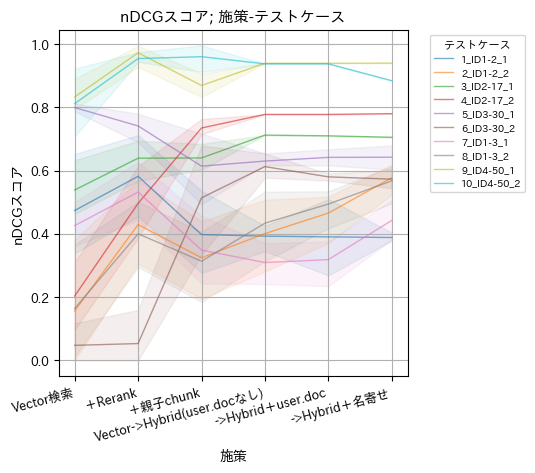

In [5]:
fig, ax = plt.subplots(figsize=(4.5,4.5))

wdf = nDCG_long_df.copy()
wdf = wdf.query("Test_ID!='平均'")

sns.lineplot(data=wdf, x='logic', y='nDCG Score', hue='Test_ID',
             linewidth=1.0, alpha=0.6, err_kws={'alpha': 0.09}, ax=ax) # 線を細く、線・網掛部分を薄く

ax.set_title('nDCGスコア; 施策-テストケース', fontsize=11) # タイトル
ax.legend(fontsize=7,
          title='テストケース', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('施策')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(15)
    label.set_ha('right')  # 右寄せax.grid()
ax.grid()
plt.show()

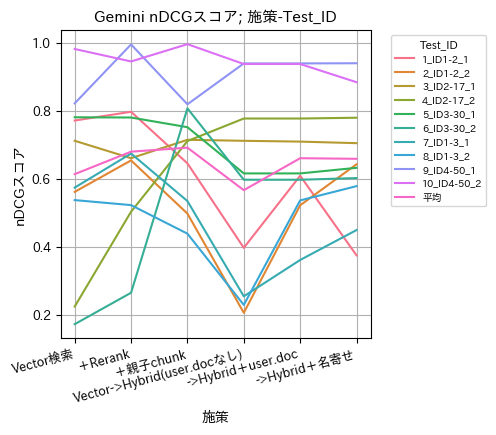

In [6]:
fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()
wdf = wdf.query("emb_model=='Gemini'")
sns.lineplot(data=wdf, x='logic', y='nDCG Score', hue='Test_ID', ax=ax)
ax.set_title('Gemini nDCGスコア; 施策-Test_ID', fontsize=11) # タイトル
ax.legend(fontsize=7,
          title='Test_ID', title_fontsize=8,            # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('施策')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(15)
    label.set_ha('right')  # 右寄せax.grid()
ax.grid()
plt.show()

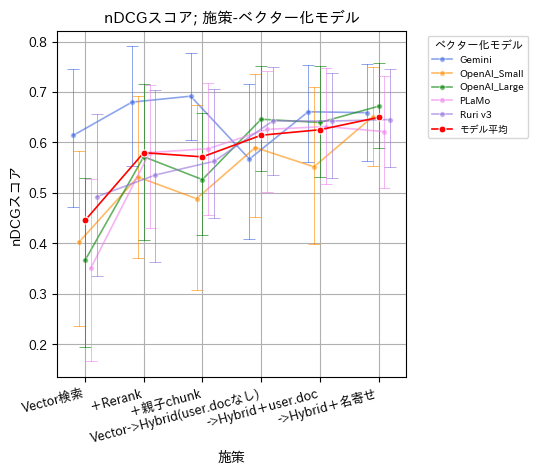

In [7]:
fig, ax = plt.subplots(figsize=(4.5,4.5))

wdf = nDCG_long_df.copy()
xdf = (
    wdf
    .groupby(['logic'], observed=True)['nDCG Score'].mean()
    .reset_index()
)

# モデルごとにx座標をずらすための値を追加
wdf_plot = wdf.copy()
wdf_plot['logic'] = wdf_plot['logic'].astype(str)
palette = {
    "Gemini": 'royalblue',
    "OpenAI_Small": 'darkorange',
    "OpenAI_Large": 'green',
    "PLaMo": 'violet',
    "Ruri v3": 'mediumpurple',
}
# jitter ------------------
models = wdf['emb_model'].unique()
n_models = len(models)
dodge_amount = 0.1  # ずらす量
# logicをカテゴリの番号に変換
logic_categories = wdf['logic'].unique()
logic_to_num = {logic: i for i, logic in enumerate(logic_categories)}
wdf_plot['logic_num'] = wdf_plot['logic'].map(logic_to_num)
# モデルごとにオフセットを計算
model_to_offset = {model: (i - (n_models - 1) / 2) * dodge_amount 
                   for i, model in enumerate(models)}
wdf_plot['offset'] = wdf_plot['emb_model'].map(model_to_offset)
wdf_plot['x_pos']  = wdf_plot['logic_num'] + wdf_plot['offset']
# 描画
sns.lineplot(data=wdf_plot, x='x_pos', y='nDCG Score', hue='emb_model',
    palette=palette, err_style='bars', 
    linewidth=1.2, alpha=0.6,  
    err_kws={'capsize': 4, 'capthick': 0.7, 'elinewidth': 0.7},
    marker='o', markersize=4, ax=ax)
# x軸のラベルを元のlogicに戻す
ax.set_xticks(range(len(logic_categories)))
ax.set_xticklabels(logic_categories)
# jitter ------------------
sns.lineplot(data=xdf, x='logic', y='nDCG Score', label='モデル平均', color='red', 
                 linewidth=1.2, marker='o', markersize=5, ax=ax)

ax.set_title('nDCGスコア; 施策-ベクター化モデル', fontsize=11) # タイトル
ax.legend(fontsize=7,
          title='ベクター化モデル', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('施策')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(15)
    label.set_ha('right')  # 右寄せax.grid()
ax.grid()
plt.show()

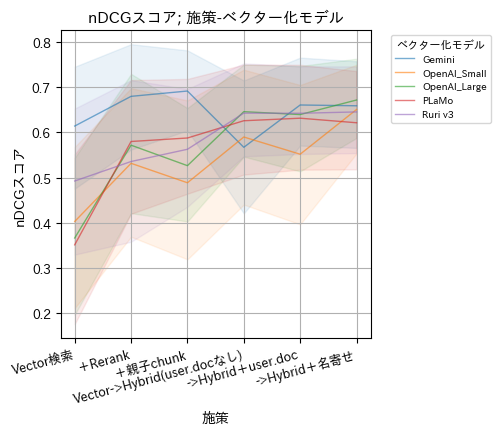

In [8]:
fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()
#wdf = wdf.query("emb_model=='Gemini'")
sns.lineplot(data=wdf, x='logic', y='nDCG Score', hue='emb_model',
             linewidth=1.0, alpha=0.6, err_kws={'alpha': 0.09}, ax=ax)
ax.set_title('nDCGスコア; 施策-ベクター化モデル', fontsize=11) # タイトル
ax.legend(fontsize=7,
          title='ベクター化モデル', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('施策')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(15)
    label.set_ha('right')  # 右寄せax.grid()
ax.grid()
plt.show()

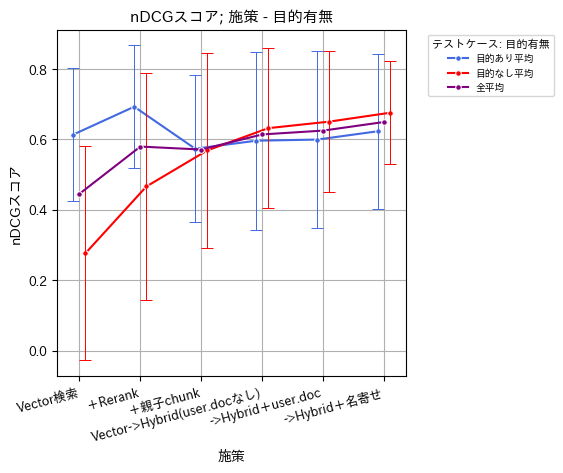

In [9]:
fig, ax = plt.subplots(figsize=(4.5,4.5))

wdf = nDCG_long_df.copy()
wdf1 = wdf[wdf['Test_ID'].str.endswith("_1")] # 目的あり
wdf2 = wdf[wdf['Test_ID'].str.endswith("_2")] # 目的なし
xdf = (
    wdf
    .groupby(['logic'], observed=True)['nDCG Score'].mean()
    .reset_index()
)
xdf1 = (
    wdf1
    .groupby(['Test_ID', 'logic'], observed=True)['nDCG Score'].mean()
    .reset_index()
)
xdf2 = (
    wdf2
    .groupby(['Test_ID', 'logic'], observed=True)['nDCG Score'].mean()
    .reset_index()
)
xdf1['logic'] = xdf1['logic'].astype(str)
xdf2['logic'] = xdf2['logic'].astype(str)

# logicをカテゴリの番号に変換
logic_categories = wdf['logic'].unique()
logic_to_num = {logic: i for i, logic in enumerate(logic_categories)}
xdf1['logic_num'] = xdf1['logic'].map(logic_to_num)
xdf2['logic_num'] = xdf2['logic'].map(logic_to_num)
xdf1['x_pos']  = xdf1['logic_num'] - 0.1
xdf2['x_pos']  = xdf2['logic_num'] + 0.1
sns.lineplot(data=xdf1, x='x_pos', y='nDCG Score', marker='o', markersize=4, 
             err_style='bars', errorbar='sd',
             err_kws={'capsize': 4, 'capthick': 0.7, 'elinewidth': 0.7},
             label='目的あり平均', color='royalblue', ax=ax)
sns.lineplot(data=xdf2, x='x_pos', y='nDCG Score', marker='o', markersize=4, 
             err_style='bars', errorbar='sd',
             err_kws={'capsize': 4, 'capthick': 0.7, 'elinewidth': 0.7},
             label='目的なし平均', color='red',       ax=ax)
ax.set_xticks(range(len(logic_categories)))
ax.set_xticklabels(logic_categories)

sns.lineplot(data=xdf,  x='logic', y='nDCG Score', marker='o', markersize=4, 
             label='全平均',     color='purple',    ax=ax)

ax.legend(fontsize=7,
          title='テストケース: 目的有無', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_title('nDCGスコア; 施策 - 目的有無', fontsize=11) # タイトル
ax.set_xlabel('施策')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(15)
    label.set_ha('right')  # 右寄せax.grid()
ax.grid()
plt.show()

#### 横軸テストケース

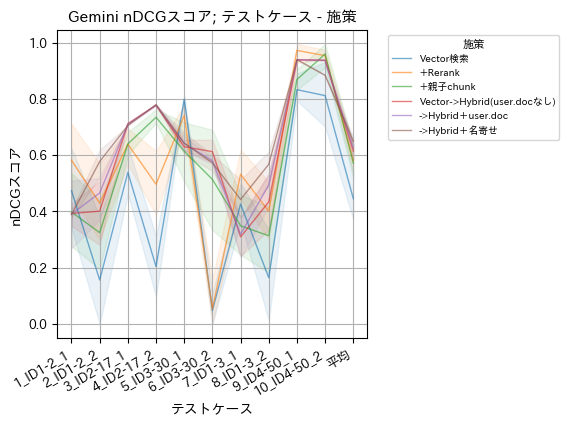

In [10]:
fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()
#wdf = wdf.query("emb_model=='Gemini'")
sns.lineplot(data=wdf, x='Test_ID', y='nDCG Score', hue='logic',
             linewidth=1.0, alpha=0.6, err_kws={'alpha': 0.09}, ax=ax)

ax.set_title('Gemini nDCGスコア; テストケース - 施策', fontsize=11)     # タイトル
ax.legend(fontsize=7,
          title='施策', title_fontsize=8,              # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',  # legendの位置
)
ax.set_xlabel('テストケース')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_ha("right")  # 右寄せ
ax.grid()
plt.show()

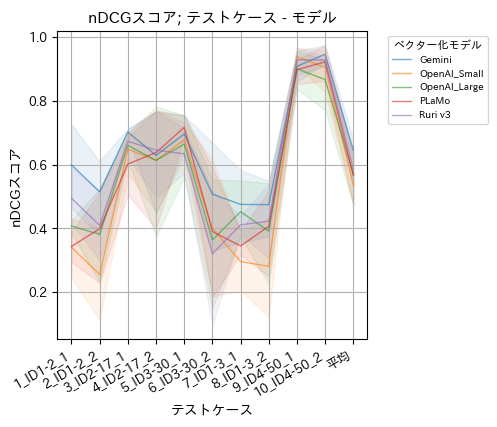

In [11]:
fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()

sns.lineplot(data=wdf, x='Test_ID', y='nDCG Score', hue='emb_model',
             linewidth=1.0, alpha=0.6, err_kws={'alpha': 0.09}, ax=ax)
ax.set_title('nDCGスコア; テストケース - モデル', fontsize=11)     # タイトル
ax.legend(fontsize=7,
          title='ベクター化モデル', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('テストケース')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_ha("right")  # 右寄せ
ax.grid()
plt.show()

C:\Users\hrish\AppData\Local\Temp\ipykernel_8320\3923030241.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Test_ID','logic'])['nDCG Score'].mean()


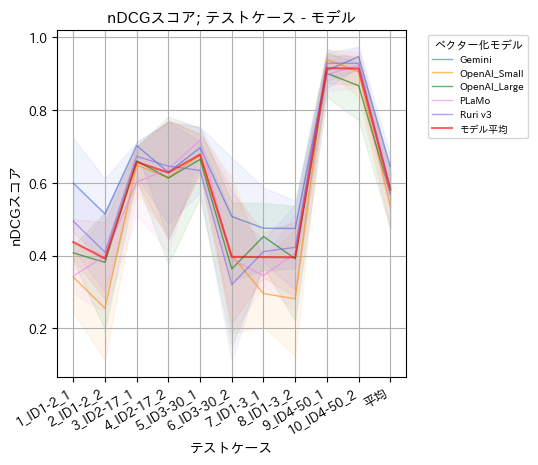

In [12]:
fig, ax = plt.subplots(figsize=(4.5,4.5))

wdf = nDCG_long_df.copy()
xdf = ( # モデル平均を計算
    wdf
    .groupby(['Test_ID','logic'])['nDCG Score'].mean()
    .reset_index()
    .assign(emb_model='モデル平均')
)
palette = { # 線の色を指定
    "Gemini": 'royalblue',
    "OpenAI_Small": 'darkorange',
    "OpenAI_Large": 'green',
    "PLaMo": 'violet',
    "Ruri v3": 'mediumslateblue',
}
sns.lineplot(data=wdf, x='Test_ID', y='nDCG Score', hue='emb_model', palette=palette,
             linewidth=1.0, alpha=0.6, err_kws={'alpha': 0.07}, ax=ax) # 線を細く、線・網掛部分を薄く
sns.lineplot(data=xdf, x='Test_ID', y='nDCG Score', label='モデル平均', color='red',
             linewidth=1.5, alpha=0.6, err_kws={'alpha': 0.05}, ax=ax)
ax.set_title('nDCGスコア; テストケース - モデル', fontsize=11)     # タイトル
ax.legend(fontsize=7,
          title='ベクター化モデル', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('テストケース')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_ha("right")  # 右寄せ
ax.grid()
plt.show()

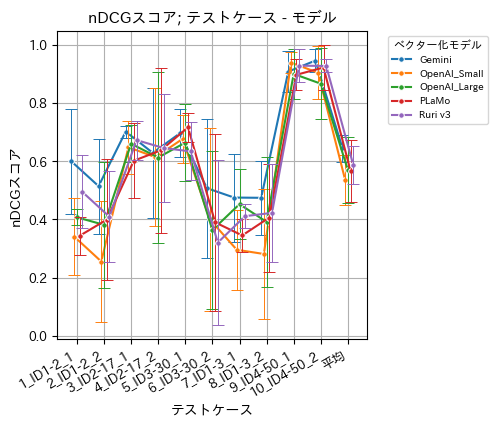

In [13]:
fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()

# jitter ------------------
# Test_IDをカテゴリの番号に変換
test_categories = wdf['Test_ID'].unique()
test_to_num = {test: i for i, test in enumerate(test_categories)}
wdf_plot['Test_ID_num'] = wdf_plot['Test_ID'].map(test_to_num)
# モデルごとにオフセットを計算
model_to_offset = {model: (i - (n_models - 1) / 2) * dodge_amount 
                   for i, model in enumerate(models)}
wdf_plot['offset'] = wdf_plot['emb_model'].map(model_to_offset)
wdf_plot['x_pos']  = wdf_plot['Test_ID_num'] + wdf_plot['offset']
# 描画
sns.lineplot(data=wdf_plot, x='x_pos', y='nDCG Score', hue='emb_model',
    err_style='bars', errorbar='sd',
    err_kws={'capsize': 4, 'capthick': 0.7, 'elinewidth': 0.7},
    marker='o', markersize=4, ax=ax)
# x軸のラベルを元のTest_IDに戻す
ax.set_xticks(range(len(test_categories)))
ax.set_xticklabels(test_categories, rotation=45, ha='right')
# jitter ------------------

ax.set_title('nDCGスコア; テストケース - モデル', fontsize=11)     # タイトル
ax.legend(fontsize=7,
          title='ベクター化モデル', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',         # legendの位置
)
ax.set_xlabel('テストケース')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_ha('right')  # 右寄せ
ax.grid()
plt.show()

#### 横軸モデル

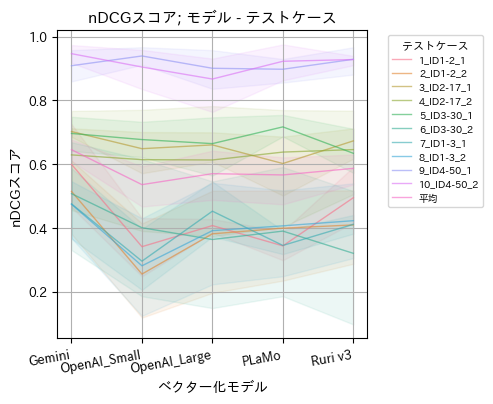

In [14]:
fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()
#wdf = wdf.query("emb_model=='Gemini'")
sns.lineplot(data=wdf, x='emb_model', y='nDCG Score', hue='Test_ID',
             linewidth=1.0, alpha=0.6, err_kws={'alpha': 0.09}, ax=ax)

ax.set_title('nDCGスコア; モデル - テストケース', fontsize=11)     # タイトル
ax.legend(fontsize=7,
          title='テストケース', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('ベクター化モデル')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(10)
    label.set_ha("right")  # 右寄せ
ax.grid()
plt.show()

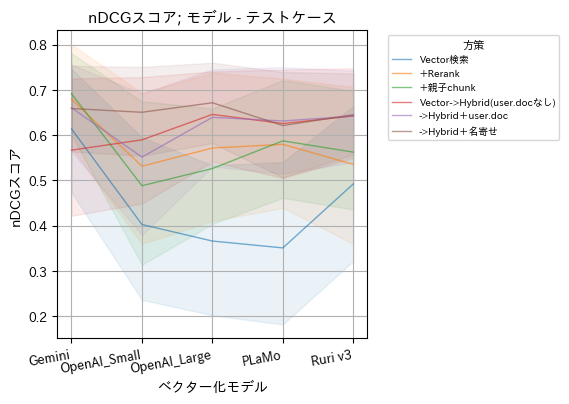

In [15]:
fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()
#wdf = wdf.query("emb_model=='Gemini'")
sns.lineplot(data=wdf, x='emb_model', y='nDCG Score', hue='logic',
             linewidth=1.0, alpha=0.6, err_kws={'alpha': 0.09}, ax=ax)

ax.set_title('nDCGスコア; モデル - テストケース', fontsize=11)     # タイトル
ax.legend(fontsize=7,
          title='方策', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('ベクター化モデル')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(10)
    label.set_ha("right")  # 右寄せ
ax.grid()
plt.show()

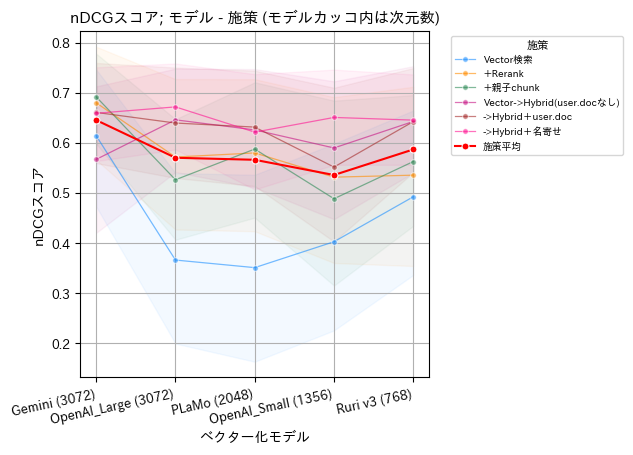

In [17]:
fig, ax = plt.subplots(figsize=(4.5,4.5))

wdf = nDCG_long_df.copy()
wdf['emb_model'] = wdf['emb_model'].replace({
    'Gemini': 'Gemini (3072)',
    'OpenAI_Small':  'OpenAI_Small (1356)',
    'OpenAI_Large':  'OpenAI_Large (3072)',
    'PLaMo':  'PLaMo (2048)',
    'Ruri v3':  'Ruri v3 (768)'
}).astype(
    pd.CategoricalDtype(
        categories=[
            'Gemini (3072)',
            'OpenAI_Large (3072)',
            'PLaMo (2048)',
            'OpenAI_Small (1356)',
            'Ruri v3 (768)'
        ],
        ordered=True
    )
)
palette = {
    'Vector検索':  'dodgerblue', #'#007FFF',
    '＋Rerank':    'darkorange', # '#FF7F00',
    '＋親子chunk': 'limegreen', # 'yellowgreen',
    'Vector->Hybrid(user.docなし)': 'magenta',
    '->Hybrid＋user.doc':  'darkcyan',
    '->Hybrid＋名寄せ':    'mediumvioletred'
}
palette = {
    'Vector検索':  'dodgerblue', #'#007FFF',
    '＋Rerank':    'darkorange', # '#FF7F00',
    '＋親子chunk': 'seagreen', # 'yellowgreen',
    'Vector->Hybrid(user.docなし)': 'mediumvioletred', # 'magenta',
    '->Hybrid＋user.doc':  'brown', # 'darkcyan',
    '->Hybrid＋名寄せ':    'deeppink', # 'mediumvioletred'

}
'''
    "dodgerblue",   # 青
    "darkorange",   # オレンジ
    "seagreen",     # 緑
    "purple",       # 紫
    "saddlebrown",  # 茶（黄系の代替：yellow は見づらいので避ける）
    "deeppink",     # ピンク（赤と被りにくい系）
'''
#display(wdf.head(10))
xdf = (
    wdf
    .groupby(['emb_model'], observed=True)['nDCG Score'].mean()
    .reset_index()
).assign(logic='施策平均')
#display(xdf.head(10))
sns.lineplot(data=wdf, x='emb_model', y='nDCG Score', hue='logic',
             linewidth=0.9, alpha=0.6, err_kws={'alpha': 0.05}, 
             palette=palette, marker='o', markersize=4, ax=ax)
sns.lineplot(data=wdf, x='emb_model', y='nDCG Score', label='施策平均',
             linewidth=1.5, color='red', err_kws={'alpha': 0.0}, 
             marker='o', markersize=5, ax=ax)

ax.set_title('nDCGスコア; モデル - 施策 (モデルカッコ内は次元数)', fontsize=11)
ax.legend(fontsize=7,
          title='施策', title_fontsize=8, 
          bbox_to_anchor=(1.05, 1), loc='upper left',
)
ax.set_xlabel('ベクター化モデル')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(12)
    label.set_ha("right")  # 右寄せ
ax.grid()
plt.show()

#### 目的有無の差

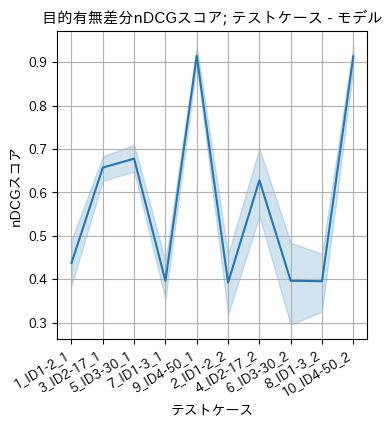

In [30]:
# 目的有/無を左右に寄せてみた描画

fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()
wdf = wdf.query("Test_ID!='平均'")
#wdf = wdf.query("logic=='->Hybrid＋名寄せ'")

wdf['Test_ID'] = wdf['Test_ID'].replace({
    '2_ID1-2_2': 'A',
    '4_ID2-17_2': 'B',
    '6_ID3-30_2': 'C',
    '8_ID1-3_2': 'D',
    '10_ID4-50_2': 'E',
})
#wdf = wdf.groupby(['Test_ID'])['nDCG Score'].mean().reset_index()
wdf = wdf.sort_values(['Test_ID'])
wdf['Test_ID'] = wdf['Test_ID'].replace({
    'A': '2_ID1-2_2',
    'B': '4_ID2-17_2',
    'C': '6_ID3-30_2',
    'D': '8_ID1-3_2',
    'E': '10_ID4-50_2',
})

sns.lineplot(data=wdf, x='Test_ID', y='nDCG Score', ax=ax)
ax.set_title('目的有無差分nDCGスコア; テストケースの平均', fontsize=11) 
ax.set_xlabel('テストケース')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_ha("right")  # 右寄せ
ax.grid()
plt.show()

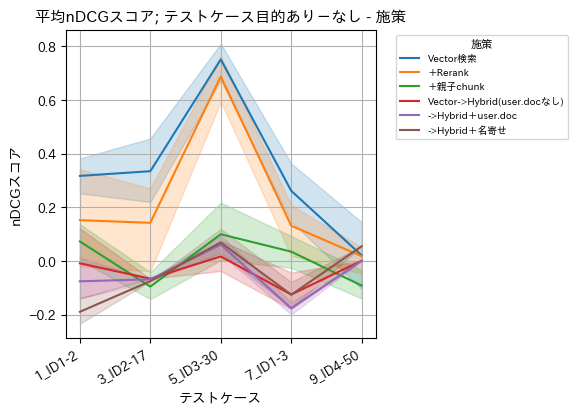

,Test_ID,logic,emb_model,nDCG_Score_1,nDCG_Score_2,nDCG Score
0,1_ID1-2,Vector検索,Gemini,0.771272,0.562039,0.209233
90,1_ID1-2,Vector->Hybrid(user.docなし),PLaMo,0.300827,0.508262,-0.207435
45,1_ID1-2,＋Rerank,Ruri v3,0.724483,0.219097,0.505386
25,1_ID1-2,＋Rerank,Gemini,0.797014,0.654448,0.142566
85,1_ID1-2,Vector->Hybrid(user.docなし),OpenAI_Large,0.403862,0.508616,-0.104754
80,1_ID1-2,Vector->Hybrid(user.docなし),OpenAI_Small,0.418790,0.273520,0.145270
30,1_ID1-2,＋Rerank,OpenAI_Small,0.498416,0.334411,0.164005
75,1_ID1-2,Vector->Hybrid(user.docなし),Gemini,0.397953,0.207565,0.190388
70,1_ID1-2,＋親子chunk,Ruri v3,0.420129,0.424896,-0.004767
35,1_ID1-2,＋Rerank,OpenAI_Large,0.444287,0.388788,0.055499


In [31]:
# 目的有無の差分を描画

fig, ax = plt.subplots(figsize=(4,4))

wdf = nDCG_long_df.copy()
wdf = wdf.query("Test_ID!='平均'")
#wdf = wdf.query("logic=='->Hybrid＋名寄せ'")

df1 = (
    wdf[wdf['Test_ID'].str.endswith("_1")]
    .rename(columns={'nDCG Score': 'nDCG_Score_1',})
    .reset_index(drop=True).copy()
)
df2 = (
    wdf[wdf['Test_ID'].str.endswith("_2")]
    .rename(columns={'nDCG Score': 'nDCG_Score_2',})
    .reset_index(drop=True).copy()
)
df1['Test_ID'] = df1['Test_ID'].str.replace(r'_1$', '', regex=True) 
df2['Test_ID'] = df1['Test_ID'].str.replace(r'_2$', '', regex=True) 
wdf = pd.merge(df1,df2, on=['Test_ID','logic','emb_model'], how='left')
wdf['nDCG Score'] = wdf['nDCG_Score_1'] - wdf['nDCG_Score_2'] 

sns.lineplot(data=wdf, x='Test_ID', y='nDCG Score', hue='logic',
             linewidth=1.0, alpha=0.6, err_kws={'alpha': 0.09}, ax=ax)
ax.set_title('平均nDCGスコア; テストケース目的あり－なし - 施策', fontsize=11)
ax.legend(fontsize=7,
          title='施策', title_fontsize=8,    # 凡例タイトル 
          bbox_to_anchor=(1.05, 1), loc='upper left',   # legendの位置
)
ax.set_xlabel('テストケース')
ax.set_ylabel('nDCGスコア')
ax.tick_params(axis='both', labelsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_ha("right")  # 右寄せ
ax.grid()
plt.show()

display(wdf.sort_values('Test_ID'))